# Machine Learning Tutorial
## (supervised learning version)

## Pietro Vischia (Universidad de Oviedo and ICTEA), pietro.vischia@cern.ch

### originally prepared for ICNFP 2022 (Kolympari, Crete)

In [1]:
# Uncomment and run this if you are running on Colab (remove only the "#", keep the "!").
# You can run it anyway, but it will do nothing if you have already installed all dependencies
# (and it will take some time to tell you it is not gonna do anything)


from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/"
! git clone https://github.com/vischia/machine_learning_tutorial.git
%cd machine_learning_tutorial
!pwd
!ls
# ! pip install -r requirements.txt

In [6]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import os
import re
import math
import socket
import json
import pickle
import gzip
import copy
import array
import numpy as np
import numpy.lib.recfunctions as recfunc

from scipy.optimize import newton
from scipy.stats import norm

import datetime
from timeit import default_timer as timer

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.tree import export_graphviz
from sklearn.inspection import permutation_importance
try:
    # See #1137: this allows compatibility for scikit-learn >= 0.24
    from sklearn.utils import safe_indexing
except ImportError:
    from sklearn.utils import _safe_indexing
    
from livelossplot import PlotLossesKeras

from keras.losses import mean_squared_error, binary_crossentropy
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Concatenate
from keras.layers import Lambda, Activation
from keras.optimizers import SGD
from tensorflow.keras.optimizers.legacy import Adam # for macos
# from keras.optimizers import Adam # for non-macos
from keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU

import keras
from keras import backend as K
import tensorflow as tf
import pandas as pd

import shap
shap.initjs()


In [7]:
INPUT_FOLDER = './'
HAVE_GPU = True


We will use the [HEP-mass dataset](http://archive.ics.uci.edu/ml/datasets/hepmass) hosted by UCIrvine together with many other datasets used to test machine learning applications.

This dataset provides top pair production events as a background, and the classification task is to separate them from events generated by a high-mass resonance (masses of 500--1000 GeV). The larger the mass, the easiest the prediction task.

The label is 1 for signal, and 0 for background. There are 27 normalized features, divided into 22 low-level ones and 5 high-level ones. Because of time constraints, we won't explore the topic of pitting low-level and high-level features against each other or of mixing them, but you are encouraged to play with them later.

<img src="hepmass.png" alt="masses from 1601.07913" style="width:50%;"/>

(figure from [1601.07913](https://arxiv.org/abs/1601.07913))

In [8]:
# Do not set these to True in the live tutorial, 
# otherwise you will clog the conference venue connection for nothing.
# The skimmed files are already included in this repository

createLowMass=False
createHighMass=False

if createLowMass:
    ! wget http://archive.ics.uci.edu/ml/machine-learning-databases/00347/not1000_train.csv.gz
    ! wget http://archive.ics.uci.edu/ml/machine-learning-databases/00347/not1000_test.csv.gz
    cols=["label", "f0", "f1", "f2", "f3", "f4", "f5", "f6", "f7", "f8", "f9", "f10", "f11", "f12", "f13",
          "14f", "15f", "f16", "f17", "f18", "f19", "f20", "f21", "f22", "f23", "f24", "f25", "f26", "mass"]
    
    train_set = pd.read_csv('./not1000_train.csv.gz', index_col=False, names=cols, header=0)
    test_set = pd.read_csv('./not1000_test.csv.gz', index_col=False, names=cols, header=0)

    # Here we exploit the fact that the background has an assigned random mass sampled from
    # the same set than that of the signal. Therefore we can just require the mass to be 500
    # without having to check for the signal and background label.
    # A final test ensures the amount of events is approximately the same.
    
    # In the data set, for some reason the "mass 500" is encoded as 499.999969, but "==499.999969" does not
    # match any entry. We will therefore use "<501" to select the events with mass=500

    train_set=train_set[train_set['mass']<501]
    test_set=test_set[test_set['mass']<501]

    print('Full train', len(train_set),
          len(train_set[train_set['label']==1]),
          len(train_set[train_set['label']==0]))
    print('Full test', len(test_set),
          len(test_set[test_set['label']==1]),
          len(test_set[test_set['label']==0]))

    train_set_temp=train_set.head(10000)
    test_set_temp=test_set.head(10000)

    train_set_temp.to_csv('data/not1000_train_medium.csv')
    test_set_temp.to_csv('data/not1000_test_medium.csv')


    train_set_temp=train_set.head(1000)
    test_set_temp=test_set.head(1000)

    train_set_temp.to_csv('data/not1000_train_small.csv')
    test_set_temp.to_csv('data/not1000_test_small.csv')


if createHighMass: # Not needed, I included the small and medium sets in the github repository
    
    ! wget http://archive.ics.uci.edu/ml/machine-learning-databases/00347/1000_train.csv.gz
    ! wget http://archive.ics.uci.edu/ml/machine-learning-databases/00347/1000_test.csv.gz
    # This needs to be run only once
    cols=[label_name, "f0", "f1", "f2", "f3", "f4", "f5", "f6", "f7", "f8", "f9", "f10", "f11", "f12", "f13", "14f", "15f", "f16", "f17", "f18", "f19", "f20", "f21", "f22", "f23", "f24", "f25", "f26"]
    train_set = pd.read_csv('./1000_train.csv.gz', index_col=False, names=cols, header=0)
    test_set = pd.read_csv('./1000_test.csv.gz', index_col=False, names=cols, header=0)

    # Randomly pick 10000 events from the full data set
    train_set_temp=train_set.head(10000)
    test_set_temp=test_set.head(10000)

    train_set_temp.to_csv('data/1000_train_medium.csv')  
    test_set_temp.to_csv('data/1000_test_medium.csv')
    
    # Randomly pick 1000 events from the full data set
    train_set_temp=train_set.head(1000)
    test_set_temp=test_set.head(1000)

    train_set_temp.to_csv('data/1000_train_small.csv')  
    test_set_temp.to_csv('data/1000_test_small.csv')


In [9]:
# Load the chosen set
train_set=pd.read_csv('data/not1000_750_train_medium.csv', index_col=False)
test_set=pd.read_csv('data/not1000_750_test_medium.csv', index_col=False)

# Drop mass info, if needed (the "1000..." files don't have a 'mass' column)
if 'mass' in train_set.columns:
    train_set=train_set.drop(['mass'], axis=1)
    test_set=test_set.drop(['mass'], axis=1)
train_set.head()

,Unnamed: 0,label,f0,f1,f2,f3,f4,f5,f6,f7,...,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26
0,1,1.0,-1.401979,-0.942620,1.049402,1.637764,1.681190,-0.005984,0.733926,-0.476641,...,-0.815440,-0.822903,0.156014,-0.197154,1.743123,0.361093,-0.941934,0.026127,1.396366,-0.123928
1,12,0.0,-0.646328,0.132367,0.864149,0.596158,0.266139,-1.054221,-0.801212,0.231854,...,1.226331,-1.368451,-0.189723,-1.710976,-0.573682,-0.800589,-0.594036,-0.377533,-0.113845,-1.300184
2,13,1.0,-0.093261,0.168337,1.287353,0.319592,-1.359426,1.574625,0.988875,-0.268706,...,-0.815440,1.634929,-0.067125,-1.548938,1.743123,-0.015264,-0.080968,0.756942,0.879847,0.218808
3,16,1.0,1.205673,1.103310,-1.132657,-1.284128,-0.823548,0.850488,0.943595,0.516031,...,1.226331,0.383688,-0.162711,1.030514,-0.573682,-0.739276,-0.147738,-0.270474,-0.256237,0.318978
4,19,0.0,-1.134711,1.257473,-0.419845,-0.848054,-1.568315,-1.054221,-0.144344,-0.077036,...,-0.815440,-0.278497,0.340343,0.306618,-0.573682,-0.384413,-0.364842,-0.309805,-0.673690,-0.957803


In [10]:
print('Training set has', len(train_set), 'entries (', len(train_set[train_set['label']==1]), 'signal entries, ',
      len(train_set[train_set['label']==0]), ' background entries)')

Training set has 10000 entries ( 5002 signal entries,  4998  background entries)


### Split the data set into training and test set

When we train a machine learning algorithm, we are trying to solve an interpolation problem (*find the function of the input features that provides the best approximation of the true function*) by also requiring that the solution generalizes sufficiently well (*the interpolating function must also predict correctly the value of the true function for new, unseen data*).


When we have a labelled dataset, we will therefore split it into: a *training set*, which we will use to train the machine learning algorithm; a *test set*, which we will use to evaluate the performance of the algorithm for various realizations of the algorithm (e.g. tuning hyperparameters); and an *application set*, which are the data we are really interested in studying in the end.

For many applications, when the amount of hyperparameters tuning is moderate, application set and test set can be collapsed into a single set (usually called *test set*). This is what we will do in this tutorial.

![Blah](figs/trainingNetwork.png)

(Image: P. Vischia, [doi:10.5281/zenodo.6373442](https://doi.org/10.5281/zenodo.6373442))

For the data set that we have loaded, we don't need to do any splitting, because the data set is already split. 
If our data set needed to be split, we would do something like



In [11]:
# X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.33, random_state=42)


### Inspect the data set

The first and most important thing to do, when developing a ML application, is to inspect the data set.

Looking at the data is crucial, because it may reveal the presence of malformed or missing data (e.g. when one feature has been filled with meaningless values for some or all of the data points) and may hint at whether it is necessary to preprocess the data.

In [12]:
# Visualize dataset

import seaborn as sns
sns.set()

0.11.2


The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.


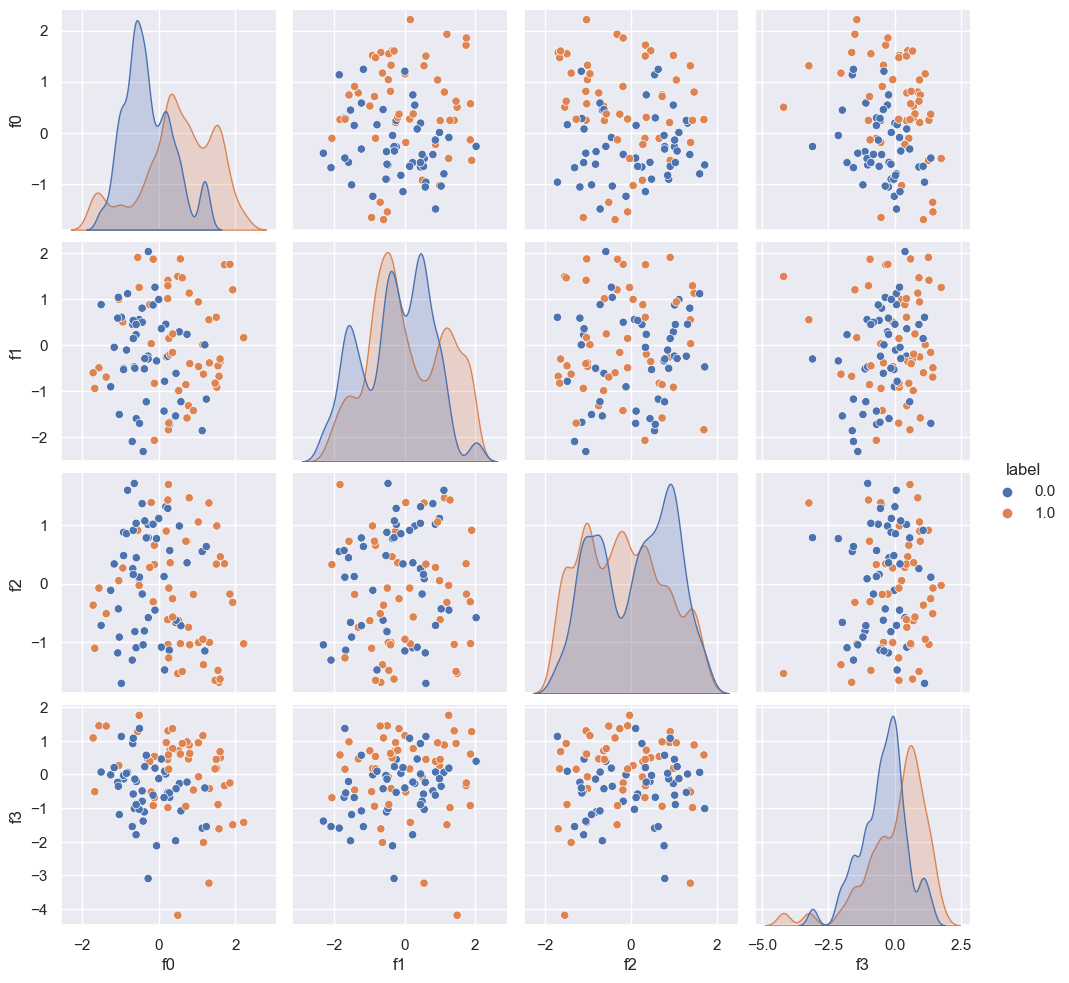

In [13]:
print(sns.__version__)

cols_to_plot = train_set.columns[1:6].tolist()

pp=sns.pairplot(data=train_set.sample(100)[cols_to_plot], hue='label', diag_kws={'bw': 0.2})
#sns.pairplot(train_set.sample(100))
plt.show()

In [14]:
pp.map_lower(sns.kdeplot, levels=4, color=".2")
plt.show(sns)

#### Correlation matrices

For classification problems, another important thing to take a look at is the correlation matrix between all the variables, in events belonging to each class separately.

Looking at the correlation between features can highlight features that are strongly correlated with other ones, leading sometimes to dropping them ("*if they are almost fully correlated, then including both does not add new information*").

We look at the correlation for each class because we are very interested in pairs of features that have different correlation in one class or the other (in our example, signal or backgroun).

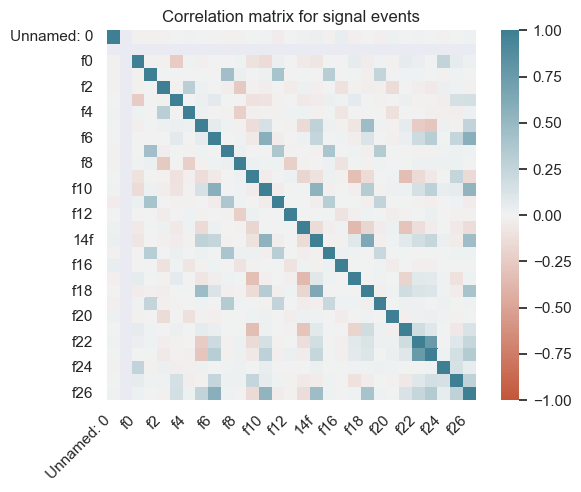

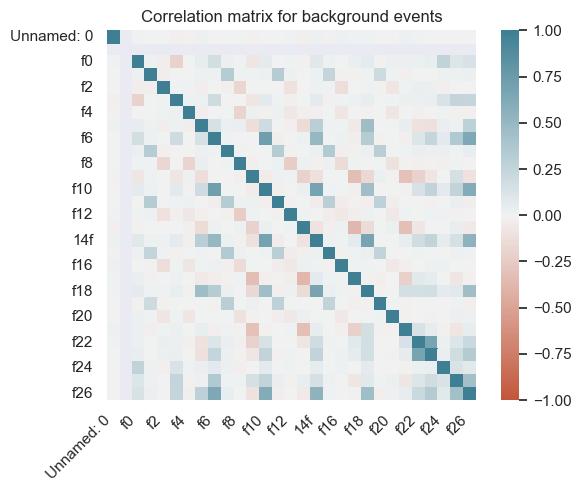

In [15]:
def corrmatrix(corr, label):
    ax = sns.heatmap(
        corr, 
        vmin=-1., vmax=1., center=0.,
        cmap=sns.diverging_palette(20., 220., n=200, as_cmap=True),
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );

    ax.set_title('Correlation matrix for %s events' % label)

    plt.show()


corrmatrix(train_set[train_set['label']==1.].corr(), 'signal')
corrmatrix(train_set[train_set['label']==0.].corr(), 'background')


What we have plotted is the Pearson correlation coefficient, which leads to an important limitation of this diagnostic tool.

The Pearson correlation coefficient captures only **linear** correlation between variables, and is blind to many nonlinear correlations that there may be. Don't trust the above matrices blindly.


![Figure from BDN2010](figs/corrcov.png)
(figure from C. Delaere slides at the 2010 BND school)

### Preprocess the data

Gradient minimization techniques like to mix numbers that are of the same order of magnitude and range.

In this data set, features are already scaled such that the range falls in the neighbourhood of unity. Sometimes this happens naturally, but in this case several variables come directly from particle physics and represent momenta of particles produced in high-energy interaction: when expressed in GeV, these variables will most certainly **not** be in a range close to unity. Therefore, we can infer that these few variables have already been preprocessed.

Common choices of preprocessing are minmax scaling or normalization.

###### Minmax

Compress the range linearly:

$$X_{scaled} = \frac{X-X_{min}}{X_{max}-X_{min}}$$

A drawback is that this results in an artificially smaller variance (the range is compressed linearly), which can deform the effect of outliers.

###### Normalization

Compress the range and the shape:

$$X_{normalized} = \frac{X - \mu}{\sigma}$$

where $\mu$ is the mean of the feature values and $\sigma$ is the standard deviation.

###### Which one?

Typically one would use minmax scaling when your features are remarkably nongaussian and your ML algorithm of choice doesn't require Gaussian inputs. The price is that it affects outliers.
Typically one would use normalization when the features are approximately Gaussian or when your ML algorithm of choice requires Gaussian inputs. However, it also results in numbers close to 1 (minimization algorithms and gradient descend love numbers that are not too large or too small), so it can be used for any algorithm: the good news is that it doesn't affect outliers.

Unfortunately, **the HEPmass dataset contains pre-normalized features, so it doesn't make sense to renormalize them**.
You are welcome to check the effect of scalers on other datasets. For reference, you can check [this `scikit-learn` post](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html) for the python code to apply scalers to input features.


### Build a simple tree-based classifier

The act of selecting regions of a data set by "cutting" (imposing thresholds) on some of the features is very natural for the particle physicist, so let's start by training a tree-based classifier.

Decision trees are precisely that:

<img src="figs/bdt_en_edit.png" alt="bdtexample" style="width:80%;"/>

(image from [r2d3.us](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/))

Decision trees depend however on the random order of imposing cuts on the data set. To reduce the dependence on the starting point and the ordering of the selection process, we will use an *ensemble* of decision trees, which will cut at random the data set, and we will *pool* the classification answers from all the trees via e.g. a majority vote.

Not all the trees resulting from the random cuts will make sense, so we will use a procedure called *boosting*, which consists in weighting each random tree based on its own performance. The weights will be used to decide how to generate the next trees.


<img src="figs/boosting.png" alt="boosting" style="width:80%;"/>


In [16]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

# Convert to numpy
X_train = train_set.loc[:, train_set.columns != 'label'].to_numpy()
y_train = train_set.loc[:, train_set.columns == 'label'].to_numpy()

X_test = test_set.loc[:, test_set.columns != 'label'].to_numpy()
y_test = test_set.loc[:, test_set.columns == 'label'].to_numpy()

bdt_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
bdt_grad = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=3, random_state=42)

In [17]:
print(X_train.shape, y_train.shape)
print(train_set.shape)
print(len(train_set.index))

(10000, 28) (10000, 1)
(10000, 29)
10000


In [18]:
fitted_bdt_ada=bdt_ada.fit(X_train, y_train.ravel())
fitted_bdt_grad=bdt_grad.fit(X_train, y_train.ravel())

### Estimate the performance of the classifier

A simple performance estimate for the classifier is the mean accuracy on a certain data set.
Let's print it out for the training set and for the test set.

In [19]:
print('Adaptive boost: train score', fitted_bdt_ada.score(X_train, y_train.ravel()),', test score', fitted_bdt_ada.score(X_test, y_test.ravel()))
print('Gradient boost: train score', fitted_bdt_grad.score(X_train, y_train.ravel()),', test score', fitted_bdt_grad.score(X_test, y_test.ravel()))

Adaptive boost: train score 0.8532 , test score 0.8315
Gradient boost: train score 0.9308 , test score 0.7997


We can observe two things:

For each dataset, the performance of gradient-based boosting is better than of adaptive boosting, which is normally expected.

For each algorithm, the performance on the test set is remarkably lower than that on the training set. Furthermore, the performance on the training set is very high. All of this is an indication that our algorithm is able to separate the two classes (signal and background) very effectively, but generalizes somehow poorly.

To study the generalization properties of machine learning algorithms we will switch to neural networks, where we can control in an intuitive way the complexity of the network.

For the moment, however, let's look at some additional ways of exploring the algorithm's performance.

#### ROC curve

In [20]:
def plot_rocs(scores_and_names, y):
    pack=[] 
    for s, n in scores_and_names: 
        fpr, tpr, thresholds = roc_curve(y.ravel(), s)
        pack.append([n, fpr,tpr,thresholds])

    plt.figure()
    lw=2
    for n, fpr, tpr, thresholds in pack:
        plt.plot(fpr, tpr, lw=lw, label="%s (AUC = %0.2f)" % (n, auc(fpr, tpr))) 

    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic curve")
    plt.legend(loc="lower right")
    plt.show()

    
y_score = fitted_bdt_ada.decision_function(X_test)


Let's now plot the ROC curve for our two classifiers

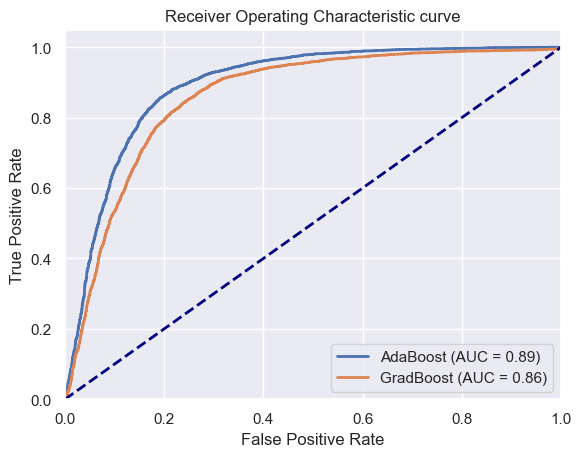

In [21]:
plot_rocs([ [fitted_bdt_ada.decision_function(X_test), 'AdaBoost'],
            [fitted_bdt_grad.decision_function(X_test), 'GradBoost']],
          y_test)

#### Inspection of the model

Plots the model structure and it correlation with a dataset.

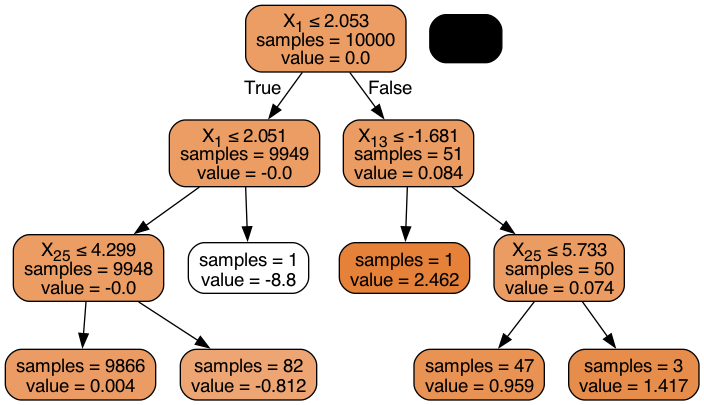

In [22]:
# Pick one of the trees (maybe modify to pick the tree with largest weight or something like that)
sub_tree_42 = fitted_bdt_grad.estimators_[42, 0]

# Visualization
# Install graphviz: https://www.graphviz.org/download/
from pydotplus import graph_from_dot_data
from IPython.display import Image
dot_data = export_graphviz(
    sub_tree_42,
    out_file=None, filled=True, rounded=True,
    special_characters=True,
    proportion=False, impurity=False, # enable them if you want
)
graph = graph_from_dot_data(dot_data)
Image(graph.create_png())

#### Explainability

A good question to pose yourself is whether the features you have chosen for your data are meaningful variables (i.e. if they are actually relevant to your classifier). Another good question is which features drive the prediction for a given event or set of events.

All these questions can be answered by using different concepts:

- **Permutation importance**: the decrease in a model score when a single feature value is randomly shuffled (scikit-learn docs) (akin to impacts for profile likelihood fits)
Shapley values: based on game theory (see other contribution)
Correlation-based: e.g. parallel coordinates in TMVA: look where each variable is mapped
to/correlated with

- **Perturbational approach**: perturbing the value of a feature and looking at the change of the prediction gives hints on how important the variable is for the method. This is at the basis of LIME (`pip install lime`). You can read more [here](https://www.oreilly.com/content/introduction-to-local-interpretable-model-agnostic-explanations-lime/)

- **Game-theoretical approach**: consider the prediction task as a game in game theory, and the features as players who bet via their values. The payout, as difference of prediction with respect to the true value, estimates how much a feature pushes the prediction away from the truth.

- **Visual approach**: parallel coordinates, which were implemented in ROOT TMVA, let you handily select a range in the prediction, and have a visual representation of which ranges of each feature is mapped into that region of the prediction.

![Parallel coordinates (reference in the figure)](figs/parcoord.png)

###### Permutation importance

The idea is: randomly shuffle one single feature value, then check how much does the prediction change. If the prediction decreases by a lot, then the value of the feature is crucial to the prediction.

Note: the importance is always **relative to a specific model**, it has no absolute validity. A feature that is deemed low-importance for a badly designed model may be deemed high-importance for a good model, and viceversa. Permutation importance scores don't "talk" across different models.

Also, if the model has a performance which is near-chance, then it is not strongly predictive, so the answers one may get from permutation importance scores are not really reliable.

In [23]:
scoring = ['r2', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error']

rs = permutation_importance(
    fitted_bdt_grad, X_test, y_test, n_repeats=30, random_state=0, scoring=scoring)

for metric in rs:
    print(f"{metric}")
    r = rs[metric]
    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            print(f"    {train_set.columns[i+1]:<8}" # +1 to skip the label in the naming
                  f"{r.importances_mean[i]:.3f}"
                  f" +/- {r.importances_std[i]:.3f}")



r2
    f6      0.522 +/- 0.016
    14f     0.207 +/- 0.010
    f26     0.134 +/- 0.009
    f3      0.122 +/- 0.008
    f0      0.115 +/- 0.008
    f18     0.107 +/- 0.008
    f10     0.087 +/- 0.006
    f5      0.008 +/- 0.003
neg_mean_absolute_percentage_error
    f6      306995374599088.812 +/- 11696264325653.875
    14f     97623027922634.469 +/- 7721787512791.877
    f3      54208327514782.875 +/- 6182118984326.836
    f0      50185111847665.227 +/- 7471708706422.143
    f18     33461745231362.789 +/- 7607529404700.310
neg_mean_squared_error
    f6      0.130 +/- 0.004
    14f     0.052 +/- 0.003
    f26     0.033 +/- 0.002
    f3      0.031 +/- 0.002
    f0      0.029 +/- 0.002
    f18     0.027 +/- 0.002
    f10     0.022 +/- 0.002
    f5      0.002 +/- 0.001


Besides looking at the more important variables, you may also look at the less important, to **prune** them.

Pruning consists in dropping the least important variables and retraining your machine learning algorithm.
The idea behind it is that the variables dropped don't influence the prediction anyway, and retraining without them should give more or less the same performance but with a simpler model. Why would we do that? Well, for example inference may be time-sensitive, and simpler models are computationally **faster** to evaluate.

##### Shapley values
(based on [this blog post](https://www.analyticsvidhya.com/blog/2019/11/shapley-value-machine-learning-interpretability-game-theory/))

Shapley values are a construct based on game theory.
The main idea behind Shapley values is to consider the prediction task for a single event as game played by the feature values of that event. The features collaborate together to play the game by betting. The value of the feature is the amount each feature bets on the prediction task. The **Shapley Value** for each feature is the payout of the game, and consists in the correct weight such that the sum of all Shapley values for the features is the difference between the predictions and the average value of the model. In other words, the Shapley value represents how much each variable pushes the prediction far from the expected value.

More concretely, the Shapley value for a feature A is computed as follows:

- Get all subsets of features that do not contain A
- Compute the effect of adding A to each of these subsets 
- Aggregate all the contributions (i.e. compute the marginal contribution of the feature over all the subsets)

In principle we should retrain the model for each of these subsets, but instead we (the `shap` package, actually) will just compute predictions by replacing the value of the feature with its own average value.



In [24]:
print(np.__version__)
explainer = shap.TreeExplainer(fitted_bdt_grad)
shap_values = explainer.shap_values(X_train)
i = 4776
shap.force_plot(explainer.expected_value, shap_values[i], features=X_train[4776], feature_names=train_set.columns[1:])

1.23.5


Values in blue represent features that push the prediction towards negative values, values in red represent features that push the prediction towards positive values, *for the event number 4776*.

We naturally want a summary of Shapley values over all observations:

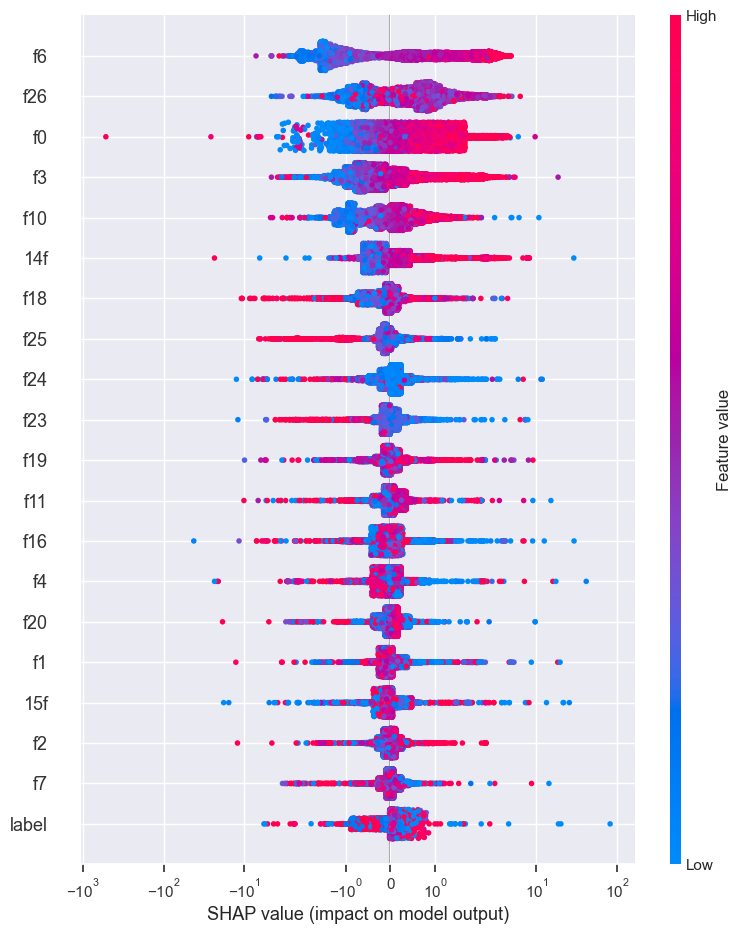

In [25]:
shap.summary_plot(shap_values, features=X_train, feature_names=train_set.columns[1:], use_log_scale=True)

#### Let's go for a neural network

We could tweak the BDT options to reduce overfitting, but it's more intuitive to do that by controlling the structure and training parameteres of a neural network.

Let's begin with a simple neural network.

<img src="figs/nn.png" alt="nn" style="width:80%;"/>

Neural networks learn by exploring the loss function landscape. We don't want to "just interpolate": we crucially also need the algorithm to **generalize** for unseen examples.

<img src="figs/vapnik.png" alt="nn" style="width:80%;"/>


<img src="figs/classicaldescent.png" alt="nn" style="width:80%;"/>


In [26]:
kernel_initializer='glorot_uniform'
n_inputs=X_train.shape[1] # Number of columns
n_hidden_layers=1 # was 0
adam_learning_rate=0.0001
batch_size = 128



<img src="figs/batch.png" alt="nn" style="width:80%;"/>


In [39]:

# Remember to comment on learning rate
def lr_scheduler(epoch):
    default_lr = 0.001
    drop = 0.9
    epochs_drop = 5.0
    lr = default_lr * math.pow(drop, math.floor(epoch/epochs_drop))
    #lr = default_lr * np.power(drop, min(1, np.floor((1 + epoch)/epochs_drop)))
                    
    return lr


##### A note about learning rate


<img src="figs/grad_desc.png" alt="nn" style="width:80%;"/>


In [40]:
n_neurons=10

nn_model = Sequential()

# Input layer (no activation function here)
nn_model.add(Dense(n_neurons, input_dim=n_inputs, kernel_initializer=kernel_initializer))

# Hidden layer
for i in range(n_hidden_layers):
    nn_model.add(Dense(n_neurons, activation='relu', kernel_initializer=kernel_initializer))

# Output layer
nn_model.add(Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer))

optimizer = Adam(learning_rate=adam_learning_rate)
nn_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])



callbacks = []
callbacks.append(keras.callbacks.ModelCheckpoint('base_nn_weights.h5', monitor='val_loss', verbose=False, save_best_only=True, mode='auto'))


# REMEMBER TO COMMENT ABOUT EARLY STOPPING
callbacks.append(keras.callbacks.LearningRateScheduler(lr_scheduler))
callbacks.append(PlotLossesKeras())

In [41]:
# Inspect the model
#import keras.vis_utils
#from importlib import reload
#reload(keras.vis_utils)


from keras.utils import plot_model
# pip install pydot
plot_model(nn_model,show_shapes=True, show_layer_names=True)
#keras.utils.plot_model(model, show_shapes=True, to_file=os.path.join(output_folder, 'model_wshapes.png'))

nn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 10)                290       
                                                                 
 dense_7 (Dense)             (None, 10)                110       
                                                                 
 dense_8 (Dense)             (None, 1)                 11        
                                                                 
Total params: 411 (1.61 KB)
Trainable params: 411 (1.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Train the network

![https://xkcd.com/303/](https://imgs.xkcd.com/comics/compiling.png)


#### Inspect the loss function

The first thing to do is to look at the loss function. People used to do that after training, but nowadays it is possible to plot the loss function in realtime during training: this is what we will be doing.

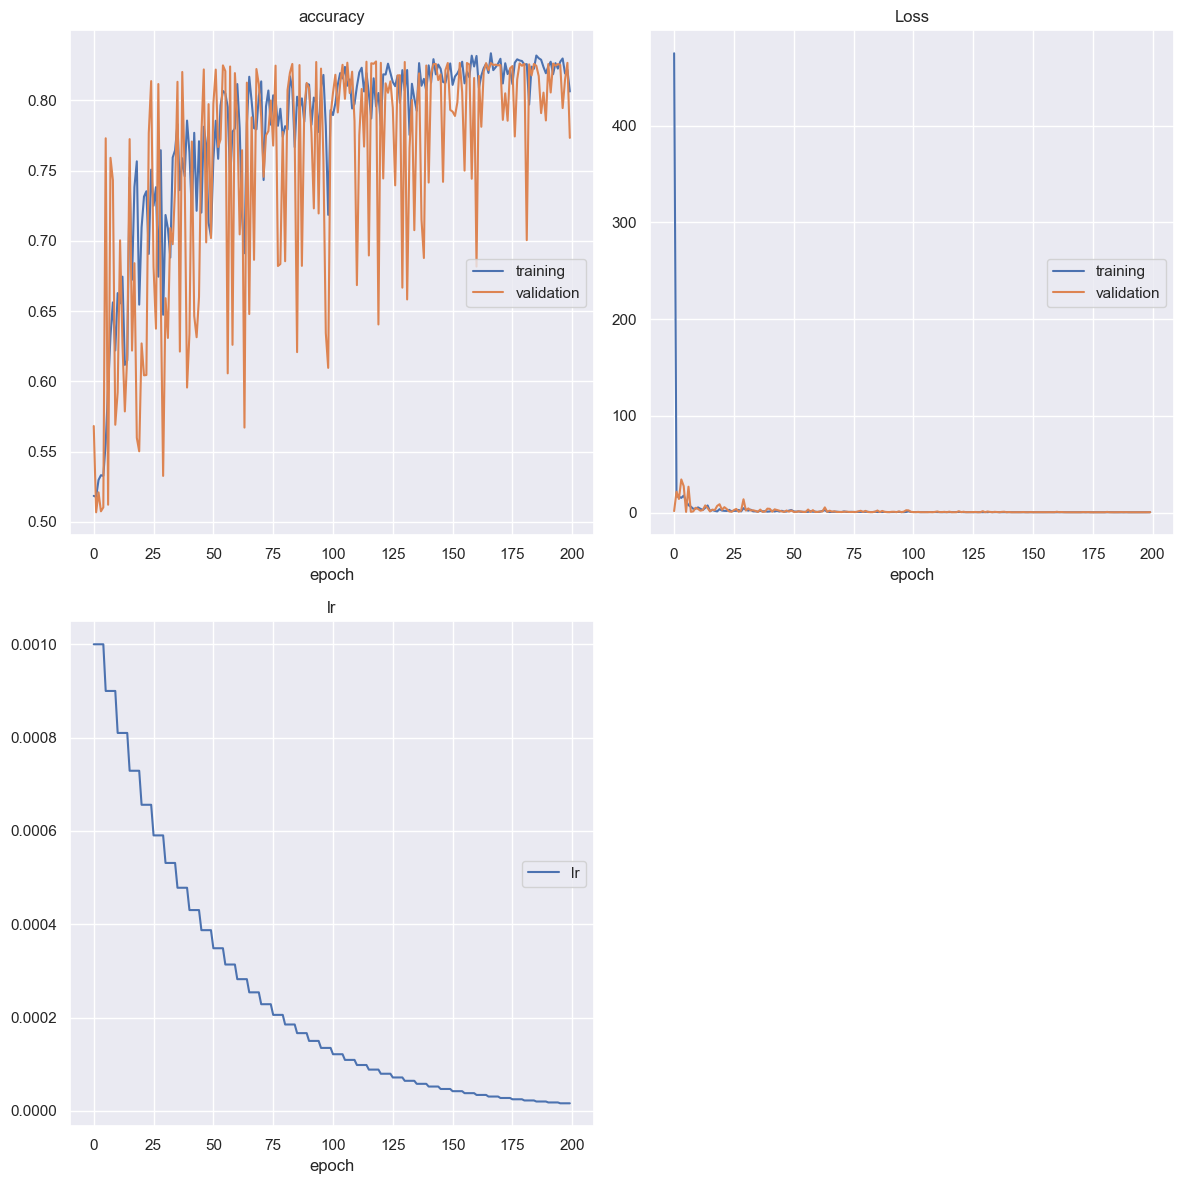

accuracy
	training         	 (min:    0.518, max:    0.834, cur:    0.806)
	validation       	 (min:    0.507, max:    0.828, cur:    0.773)
Loss
	training         	 (min:    0.448, max:  474.657, cur:    0.506)
	validation       	 (min:    0.472, max:   34.391, cur:    0.578)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
79/79 [==============================] - 1s 12ms/step - loss: 0.5058 - accuracy: 0.8063 - val_loss: 0.5784 - val_accuracy: 0.7733 - lr: 1.6423e-05
Training took 0:03:16.837323 seconds.


In [42]:
epochs = 200
start_time = timer()

history = nn_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
            verbose=True, validation_data=(X_test, y_test), callbacks=callbacks)
end_time = timer()

training_time = datetime.timedelta(seconds=(end_time - start_time))
print('Training took', training_time, 'seconds.')

# The model weights (that are considered the best) are loaded into the model.
nn_model.load_weights('base_nn_weights.h5')

## You can also save the model history for later analysis, if need be
#print("Saving model training history...")
#output_history_filename = 'chhiggs_trained_model_history.pklz'
#output_history_filename = os.path.join(output_folder, output_history_filename)
#with gzip.open(output_history_filename, 'wb') as f:
#    pickle.dump(history.history, f)


# Question: are you OK with these fluctuations? How do we eliminate them?

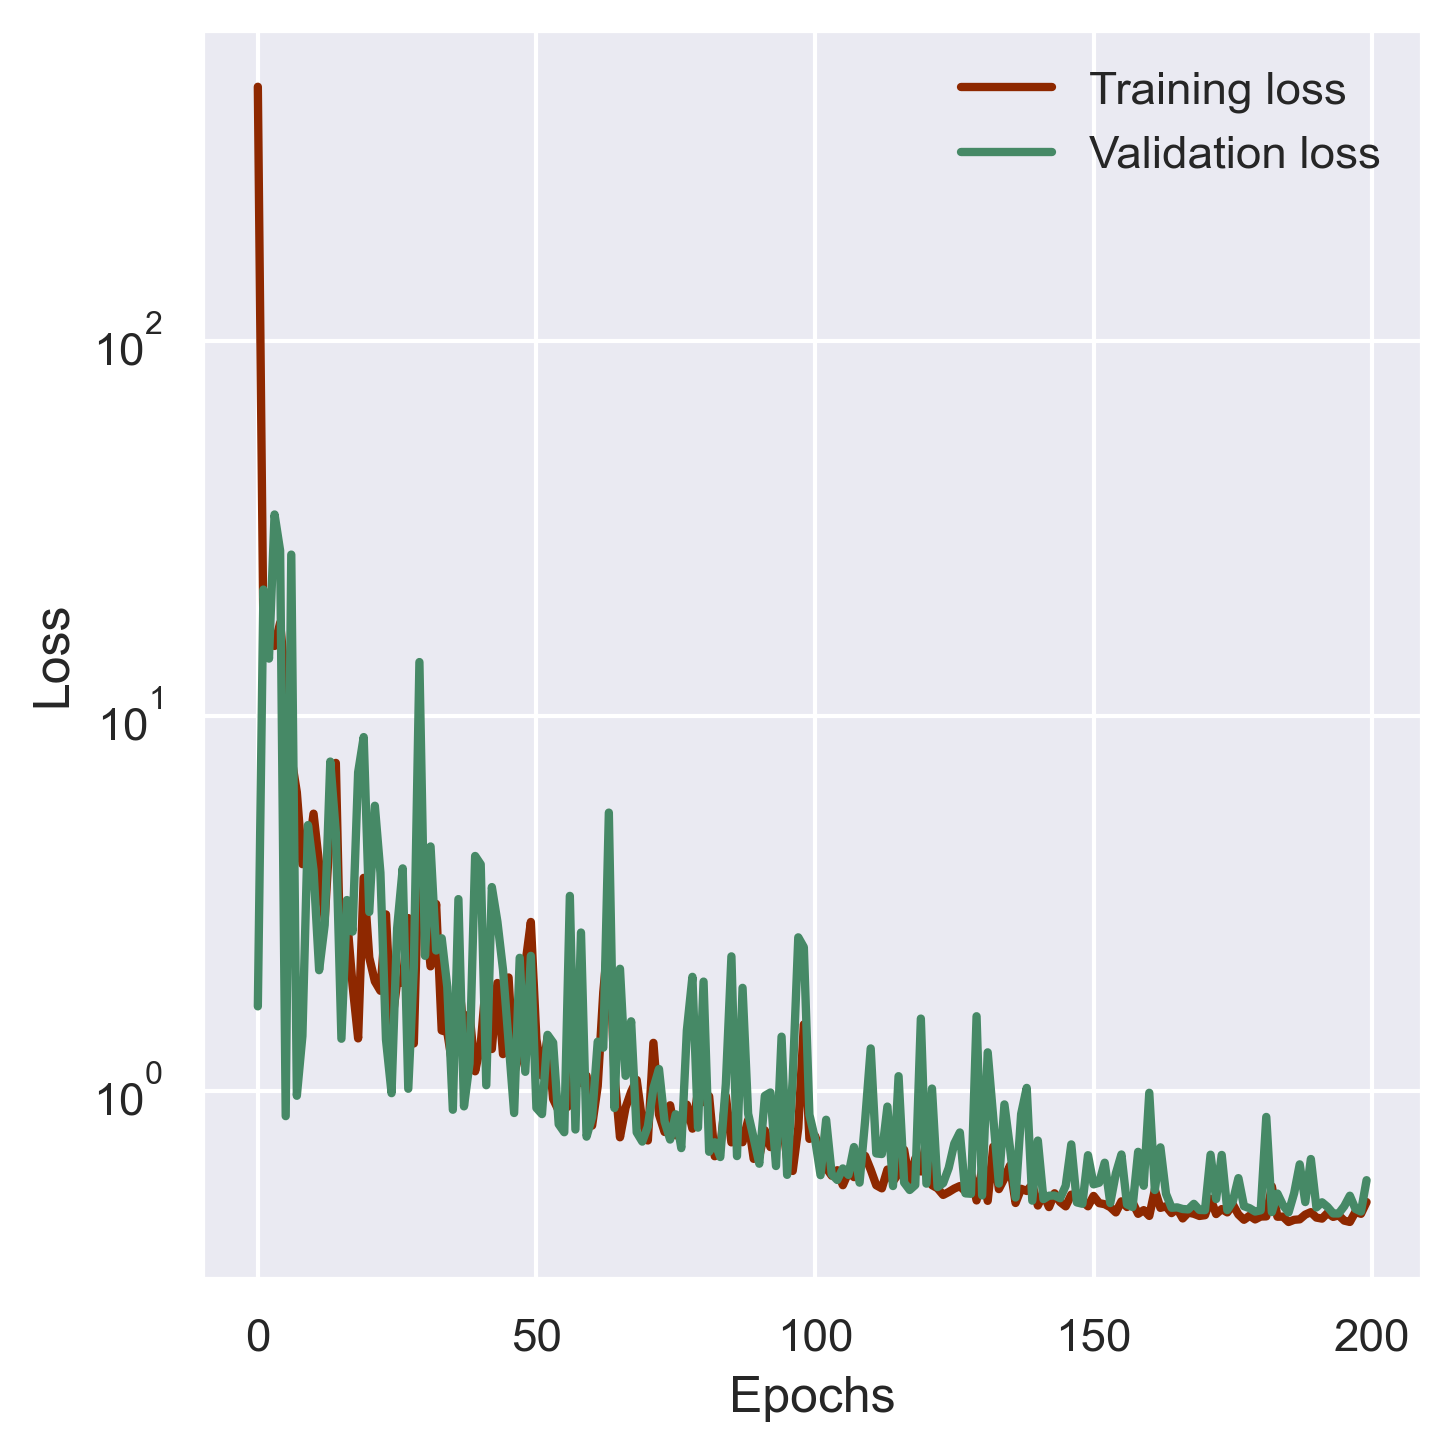

In [44]:
output_name="loss.png"

def plot_losses(history,skip=0):
    fig = plt.figure(1, figsize=(5, 5), dpi=300)
    fig.clear()

    # Create an axes instance
    ax = fig.add_subplot(111)

    if 'loss' in history.history.keys():
        training_losses = history.history['loss']
        epochs = np.arange(0, len(training_losses))
        if skip>0:
            training_losses=training_losses[skip:]
            epochs=epochs[skip:]
        l1 = ax.semilogy(epochs, training_losses, '-', color='#8E2800', lw=2, label="Training loss")
    
    if 'val_loss' in history.history.keys():
        validation_losses = history.history['val_loss']
        epochs = np.arange(0, len(validation_losses))
        if skip>0:
            validation_losses=validation_losses[skip:]
            epochs=epochs[skip:]
        l2 = ax.semilogy(epochs, validation_losses, '-', color='#468966', lw=2, label="Validation loss")

    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    
    ax.margins(0.05)

    fig.set_tight_layout(True)
    ax.legend(loc='best', numpoints=1, frameon=False)

    plt.show()
    
    
plot_losses(history,0)


#### Perfomance plots

Now that we have our trained model, we can check its performance and compare it with that of the BDTs we trained previously

In [45]:
print('Adaptive boost: train score', fitted_bdt_ada.score(X_train, y_train.ravel()),', test score', fitted_bdt_ada.score(X_test, y_test.ravel()))
print('Gradient boost: train score', fitted_bdt_grad.score(X_train, y_train.ravel()),', test score', fitted_bdt_grad.score(X_test, y_test.ravel()))
#print(nn_model.predict(X_train)[:,0] >=0.5)
print('Neural network: train score', accuracy_score(y_train.ravel(), nn_model.predict(X_train, batch_size=len(X_train))[:,0]>=0.5),', test score', accuracy_score(y_test.ravel(), nn_model.predict(X_test, batch_size=len(X_train))[:,0]>=0.5))


Adaptive boost: train score 0.8532 , test score 0.8315
Gradient boost: train score 0.9308 , test score 0.7997
1/1 [==============================] - 0s 8ms/step
Neural network: train score 0.8368 , test score 0.8257


313/313 [==============================] - 0s 1ms/step


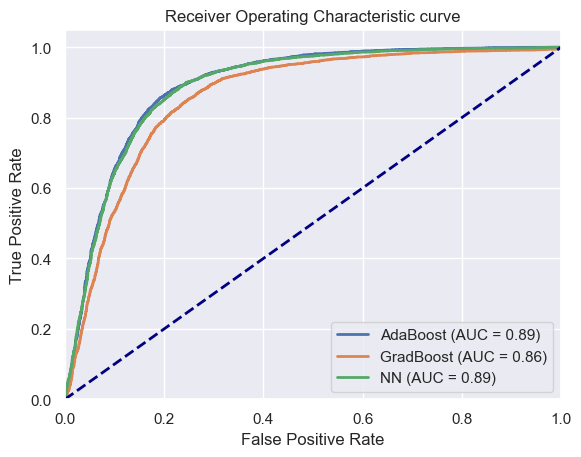

In [46]:
plot_rocs([ [fitted_bdt_ada.decision_function(X_test), 'AdaBoost'],
            [fitted_bdt_grad.decision_function(X_test), 'GradBoost'],
            [nn_model.predict(X_test)[:,0], 'NN'  ]
          ],
          y_test)

The performance of the neural network seems about the same 

#### How to fix overtraining

Overtraining broadly means that the function the neural network approximates interpolates almost perfectly the training dataset. The price for almost-perfect interpolation is usually that outside of the training set points, the function will have arbitrary values which are caused by the attempt of the network to fit perfectly the training set. As a result, the performance on the test set will be poor.

To reduce this effect, one can try to *regularize* the interpolating function, i.e. imposing some constraint on the shape it can assume. Typically this is done by requiring some amount of smoothness.

There are a couple of main ways of regularizing a neural network:

<img src="figs/regularization.png" alt="regularization" style="width:80%;"/>

Let's see how to regularise our network using dropout.

We will recreate our model, but this time we will instruct the network to drop a random fraction of neurons during the training.

In [47]:
dropout_nn_model = Sequential()

# Input layer (no activation function here)
dropout_nn_model.add(Dense(n_neurons, input_dim=n_inputs, kernel_initializer=kernel_initializer))

# Hidden layer
#dropout_nn_model.add(BatchNormalization())
dropout_nn_model.add(Dropout(0.5))
for i in range(n_hidden_layers):
    dropout_nn_model.add(Dense(n_neurons, activation='relu', kernel_initializer=kernel_initializer))
    dropout_nn_model.add(BatchNormalization())
    if i != (n_hidden_layers - 1):
        dropout_nn_model.add(Dropout(0.3))
        
# Output layer
dropout_nn_model.add(Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer))

optimizer = Adam(learning_rate=adam_learning_rate)
dropout_nn_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

callbacks = []
callbacks.append(keras.callbacks.ModelCheckpoint('dropout_nn_weights.h5', monitor='val_loss', verbose=False, save_best_only=True, mode='auto'))

callbacks.append(keras.callbacks.LearningRateScheduler(lr_scheduler))
callbacks.append(PlotLossesKeras())

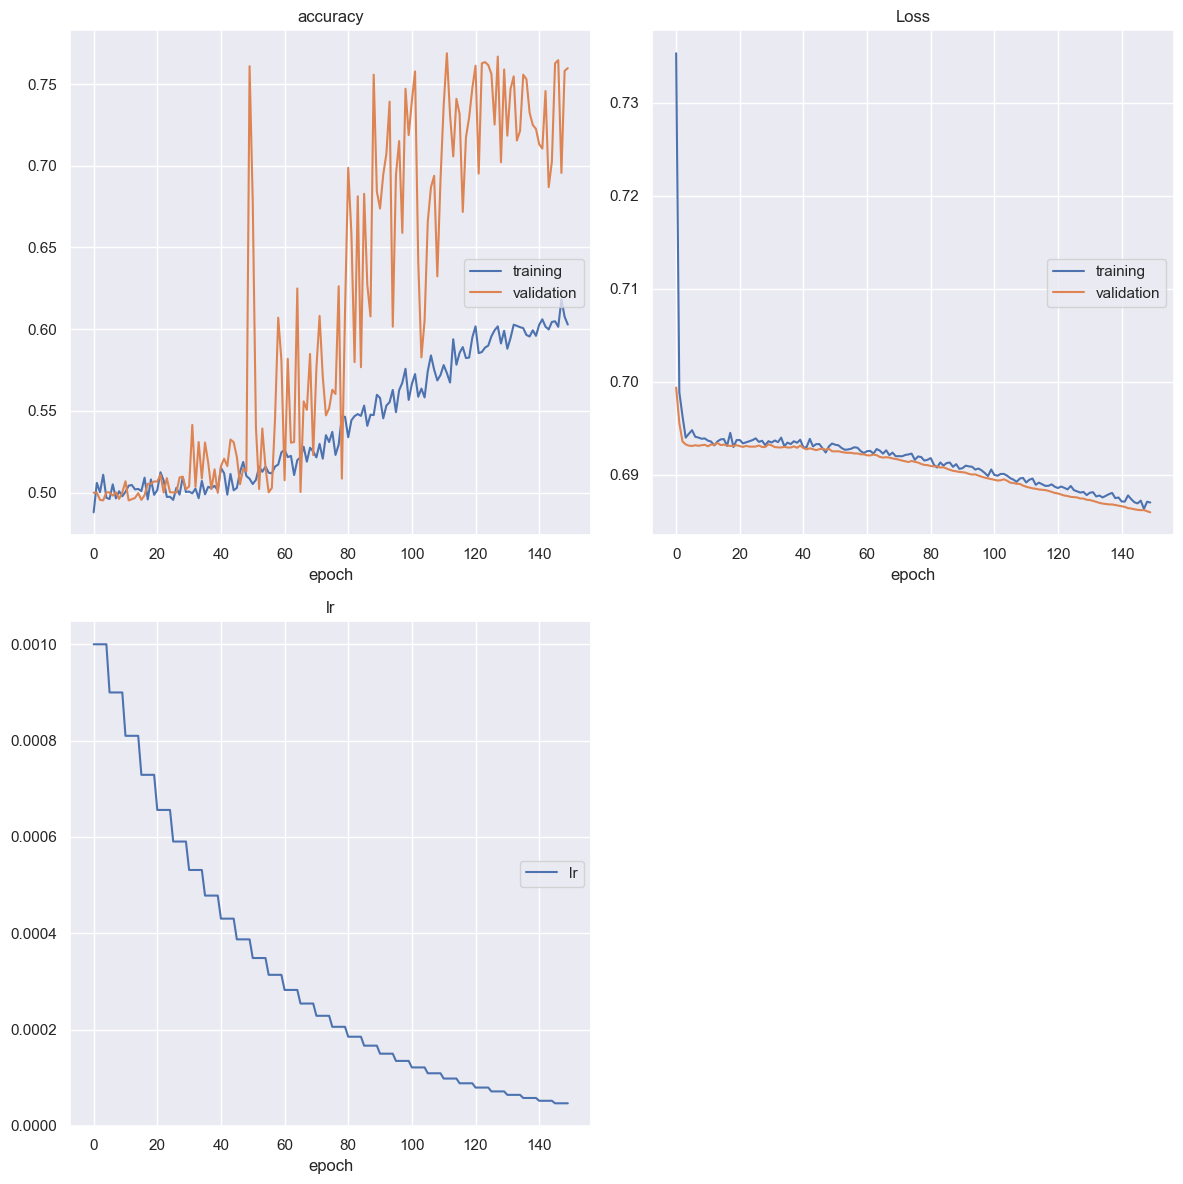

accuracy
	training         	 (min:    0.488, max:    0.618, cur:    0.603)
	validation       	 (min:    0.495, max:    0.769, cur:    0.760)
Loss
	training         	 (min:    0.686, max:    0.735, cur:    0.687)
	validation       	 (min:    0.686, max:    0.699, cur:    0.686)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
79/79 [==============================] - 1s 15ms/step - loss: 0.6870 - accuracy: 0.6028 - val_loss: 0.6860 - val_accuracy: 0.7597 - lr: 4.7101e-05
Training took 0:02:59.361149 seconds.


In [48]:
epochs = 150
start_time = timer()

dropout_history = dropout_nn_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
            verbose=True, validation_data=(X_test, y_test), callbacks=callbacks)
end_time = timer()
dropout_nn_model.load_weights('dropout_nn_weights.h5')

dropout_training_time = datetime.timedelta(seconds=(end_time - start_time))
print('Training took', dropout_training_time, 'seconds.')


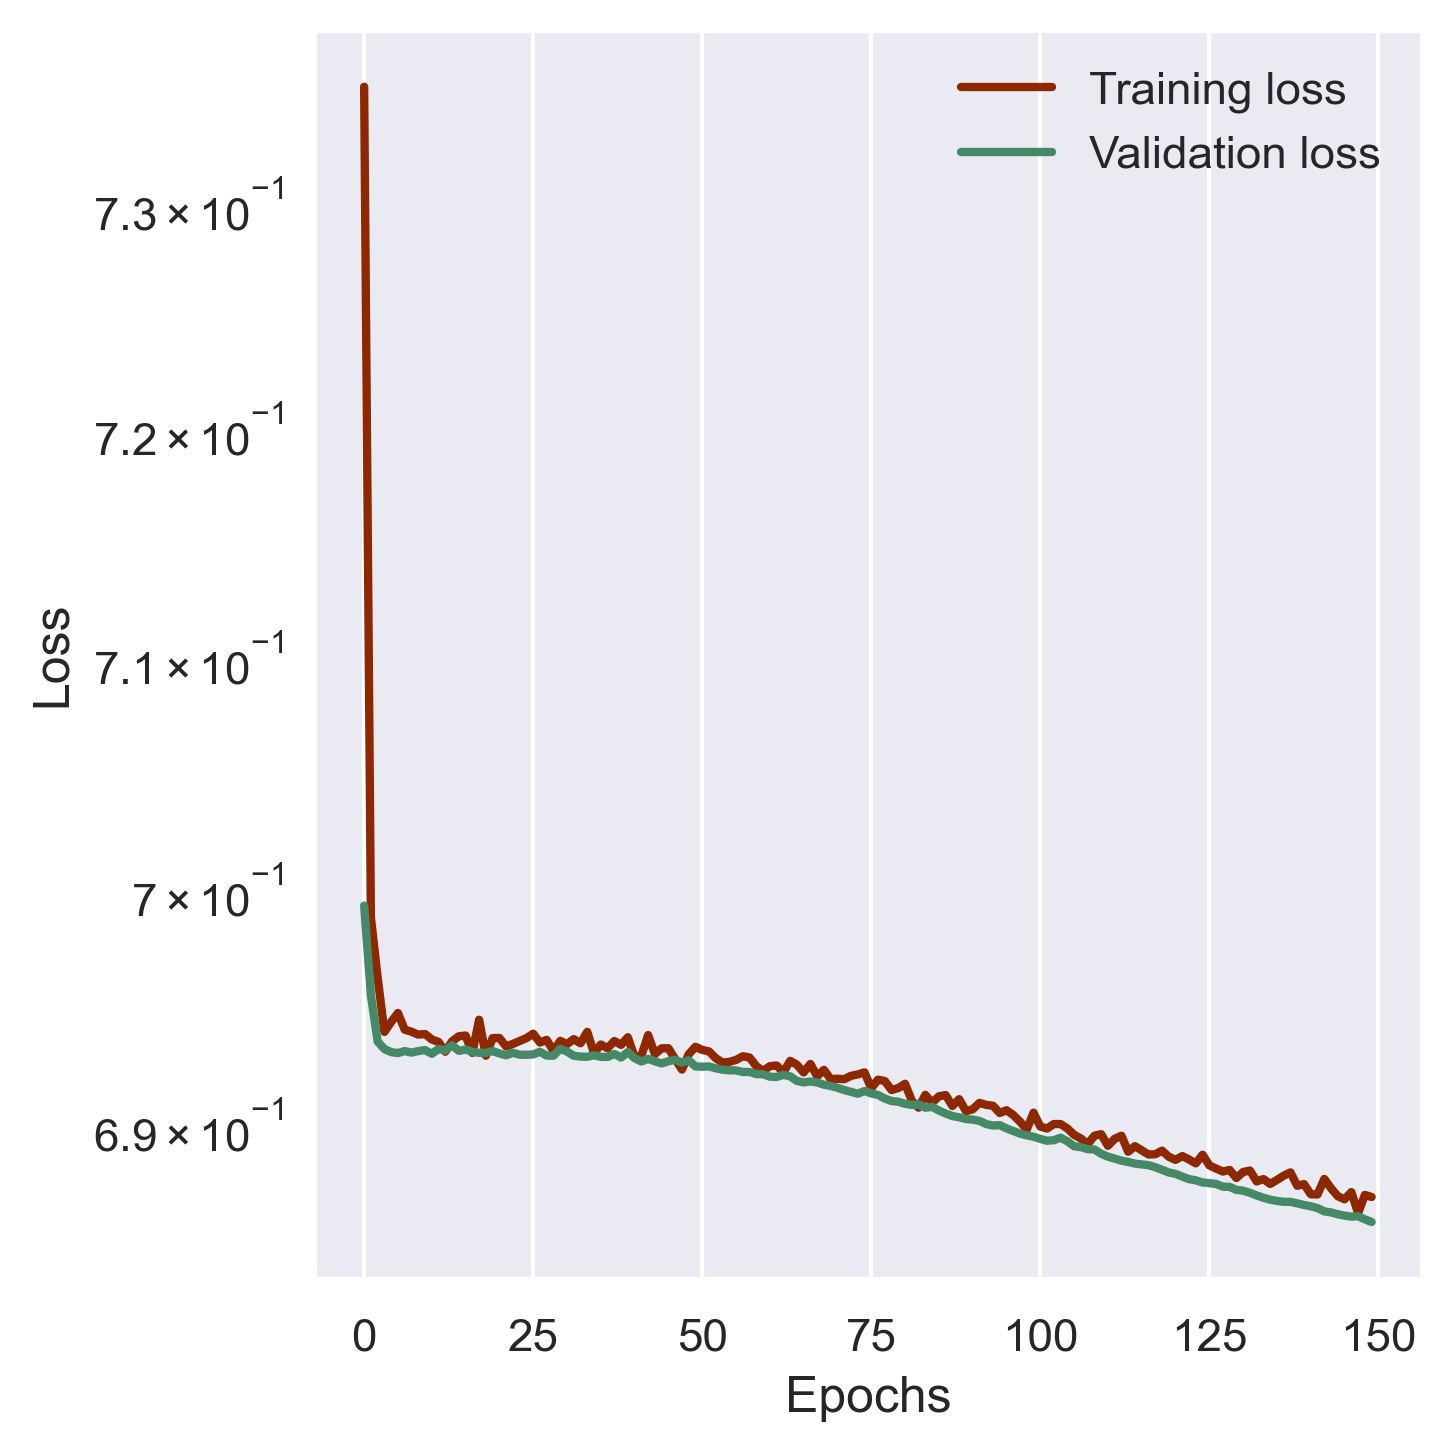

In [49]:
plot_losses(dropout_history,0)

We can already see from the loss function that there are less fluctuations in the test loss, and the test loss tend to stay flat instead of getting worse even after a large number of epochs: this is a hint that regularization is already doing its job.

Validation loss is lower than training loss: why?

- Regularization (L1/L2, or dropout)
- Once per epoch vs once per minibatch
- Noise in train/test split

Let's now look at the performance:

Adaptive boost: train score 0.8532 , test score 0.8315
Gradient boost: train score 0.9308 , test score 0.7997
1/1 [==============================] - 0s 9ms/step
NN: train score 0.8368 , test score 0.8257
1/1 [==============================] - 0s 9ms/step
NN w/ dropout: train score 0.7632 , test score 0.7597
313/313 [==============================] - 0s 1ms/step


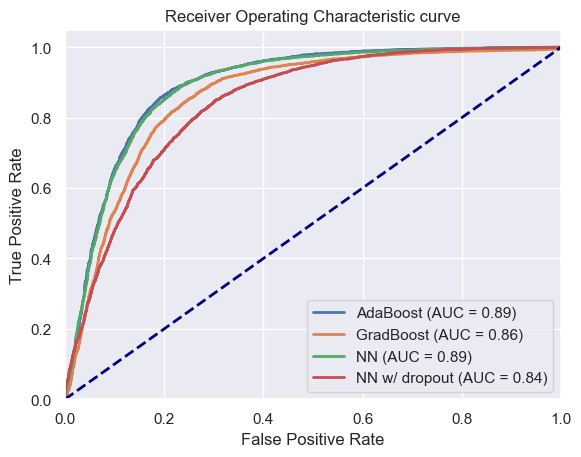

In [50]:
print('Adaptive boost: train score', fitted_bdt_ada.score(X_train, y_train.ravel()),', test score', fitted_bdt_ada.score(X_test, y_test.ravel()))
print('Gradient boost: train score', fitted_bdt_grad.score(X_train, y_train.ravel()),', test score', fitted_bdt_grad.score(X_test, y_test.ravel()))
#print(nn_model.predict(X_train)[:,0] >=0.5)
print('NN: train score', accuracy_score(y_train.ravel(), nn_model.predict(X_train, batch_size=len(X_train))[:,0]>=0.5),', test score', accuracy_score(y_test.ravel(), nn_model.predict(X_test, batch_size=len(X_train))[:,0]>=0.5))
print('NN w/ dropout: train score', accuracy_score(y_train.ravel(), dropout_nn_model.predict(X_train, batch_size=len(X_train))[:,0]>=0.5),', test score', accuracy_score(y_test.ravel(), dropout_nn_model.predict(X_test, batch_size=len(X_train))[:,0]>=0.5))

plot_rocs([ [fitted_bdt_ada.decision_function(X_test), 'AdaBoost'],
            [fitted_bdt_grad.decision_function(X_test), 'GradBoost'],
            [nn_model.predict(X_test)[:,0], 'NN'  ],
            [dropout_nn_model.predict(X_test)[:,0], 'NN w/ dropout'  ]
          ],
          y_test)

The performance of the network is almost unchanged, but the generalization error is smaller, as hinted by the smaller difference between training and test score.



#### Overparameterization!

You probably know already that modern machine learning is about models with hundreds of thousands, or even million, or billions parameters.
Very often, the number of model parameters learned from data is larger than the dimension of the dataset itself: we call this regime *overparameterized regime*.

You can think of an overparameterized regime as a model that is so complex that the available data can't provide enough information to fit it properly. Intuitively, a more complex model is so flexible that it can reach zero training error, i.e. a perfect interpolation regime, at the price of a vast generalization error, which is rather undesirable.

Empirically, however, it turns out that vastly overparameterized systems have the capability of **both fitting the training set perfectly, and generalizing very well to unseen data**, which seemingly contradicts the basic tenets of learning by interpolation.

Recent machine learning literature, however, has started studying this in detail, highlighting a phenomenon called *double descent*.

<img src="figs/doubledescent.png" alt="doubledescent" style="width:80%;"/>


This has been explained in the last 5-6 years by **implicit regularization**, in that the overparameterized system seems to converge towards **minimum norm solutions**. [More recently](https://arxiv.org/abs/2005.06398), it has been proposed that a setting where tensor factorization of the networks, demonstrated equivalent to the network themselves, exhibits a behaviour where the matrix norms converge uniformly to infinity, and that what is minimized is **the rank**. 

Let's now build a vastly overparameterized system, to show that its performance can be better than an underparameterized system.

Let's start by looking at how many learnable parameters our original neural network has

In [51]:
nn_model.summary()
dropout_nn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 10)                290       
                                                                 
 dense_7 (Dense)             (None, 10)                110       
                                                                 
 dense_8 (Dense)             (None, 1)                 11        
                                                                 
Total params: 411 (1.61 KB)
Trainable params: 411 (1.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 10)                290       
                                                                 
 d

In [37]:
# INSERT HERE DISPLAYING OF THE MODEL

SyntaxError: invalid syntax (3785014380.py, line 1)

#### Horrendously overparameterized network

Let's now build a horrendously overparameterized network, and train it.

The key insight is that we will make the number of neurons in the hidden layer jump up dramatically.

In [61]:
n_neurons=400


n_neurons_per_layer=[4*n_inputs, 4*n_inputs, n_inputs, int(n_inputs/2)]
n_hidden_layers=len(n_neurons_per_layer)

ov_nn_model = Sequential()

# Input layer (no activation function here)
ov_nn_model.add(Dense(n_neurons, input_dim=n_inputs, kernel_initializer=kernel_initializer))

# Hidden layers
for i in range(n_hidden_layers):
    ov_nn_model.add(Dense(n_neurons_per_layer[i], activation='relu', kernel_initializer=kernel_initializer))

# Output layer
ov_nn_model.add(Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer))


# NOTE: first try without the new learning rate
def lr_scheduler(epoch):
    default_lr = 0.0001
    drop = 0.9
    epochs_drop = 5.0
    lr = default_lr * math.pow(drop, math.floor(epoch/epochs_drop))
    #lr = default_lr * math.pow(drop, min(1, math.floor((1 + epoch)/epochs_drop)))
                    
    return lr
optimizer = Adam(learning_rate=0.01*adam_learning_rate)
ov_nn_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

callbacks = []
callbacks.append(keras.callbacks.ModelCheckpoint("overparam_nn_weights.h5", monitor='val_loss', verbose=False, save_best_only=True, mode='auto'))

callbacks.append(keras.callbacks.LearningRateScheduler(lr_scheduler))
callbacks.append(PlotLossesKeras())

ov_nn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 400)               11600     
                                                                 
 dense_12 (Dense)            (None, 112)               44912     
                                                                 
 dense_13 (Dense)            (None, 112)               12656     
                                                                 
 dense_14 (Dense)            (None, 28)                3164      
                                                                 
 dense_15 (Dense)            (None, 14)                406       
                                                                 
 dense_16 (Dense)            (None, 1)                 15        
                                                                 
Total params: 72,753
Trainable params: 72,753
Non-trai

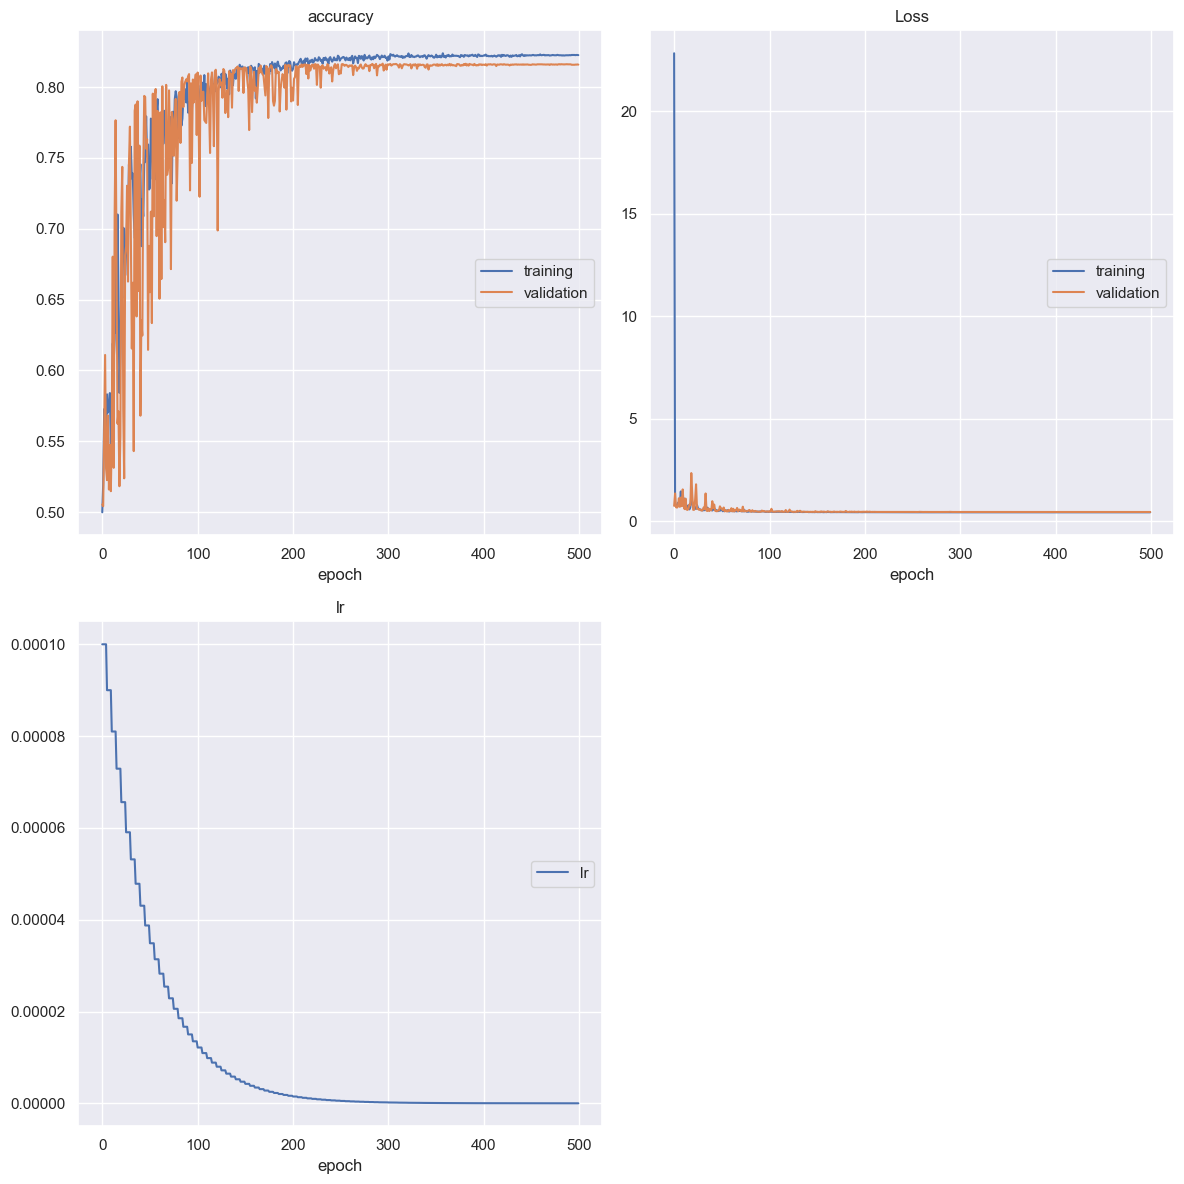

accuracy
	training         	 (min:    0.500, max:    0.824, cur:    0.823)
	validation       	 (min:    0.504, max:    0.817, cur:    0.816)
Loss
	training         	 (min:    0.429, max:   22.829, cur:    0.429)
	validation       	 (min:    0.445, max:    2.343, cur:    0.445)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)
79/79 [==============================] - 1s 13ms/step - loss: 0.4293 - accuracy: 0.8226 - val_loss: 0.4446 - val_accuracy: 0.8159 - lr: 2.9513e-09
Training took 0:08:11.218895 seconds.


In [62]:
batch_size = 128
epochs = 500
start_time = timer()

ov_history = ov_nn_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
            verbose=True, validation_data=(X_test, y_test), callbacks=callbacks)
end_time = timer()
ov_nn_model.load_weights('overparam_nn_weights.h5')

training_time = datetime.timedelta(seconds=(end_time - start_time))
print('Training took', training_time, 'seconds.')

#save_training_pa

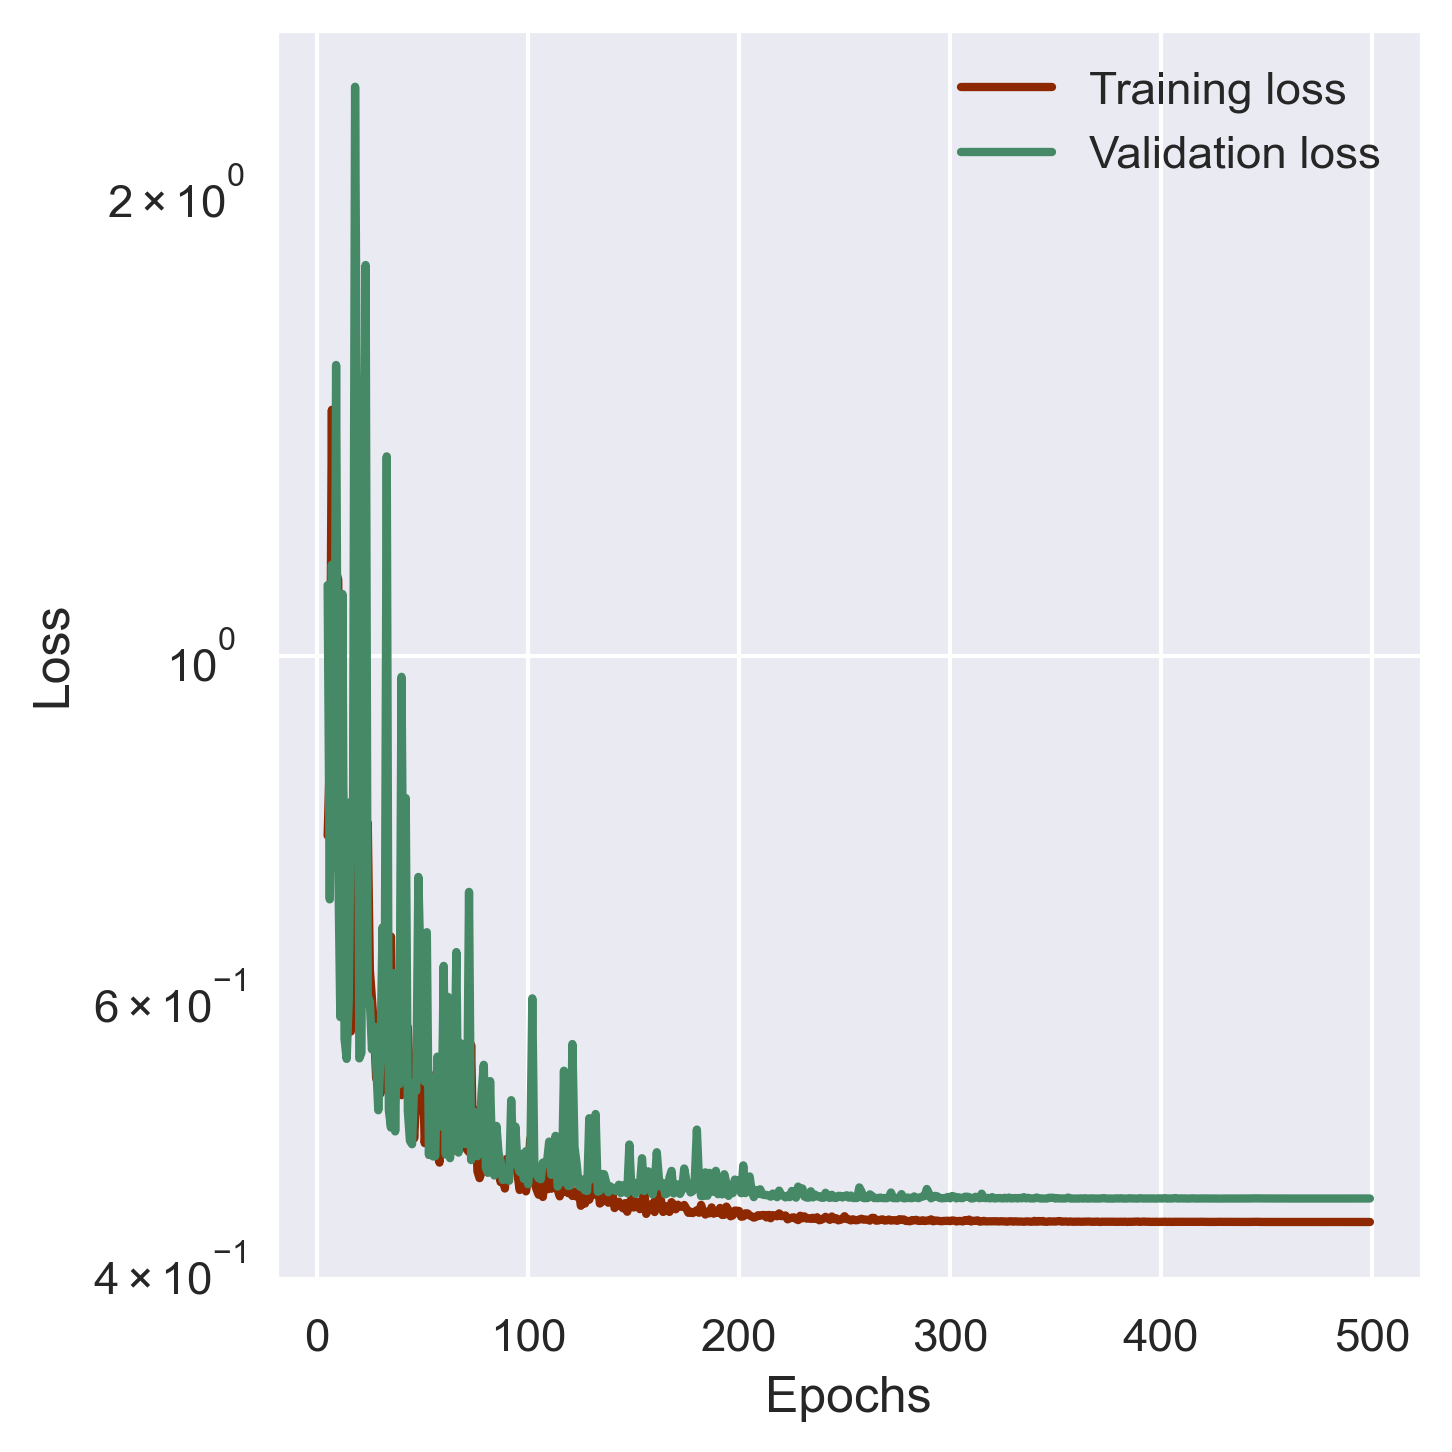

In [63]:
plot_losses(ov_history,5)

Adaptive boost: train score 0.8532 , test score 0.8315
Gradient boost: train score 0.9308 , test score 0.7997
1/1 [==============================] - 0s 8ms/step
NN: train score 0.81 , test score 0.7997
1/1 [==============================] - 0s 8ms/step
NN w/ dropout: train score 0.8372 , test score 0.8281
1/1 [==============================] - 0s 9ms/step
NN (overparameterized): train score 0.8213 , test score 0.8153
313/313 [==============================] - 1s 2ms/step


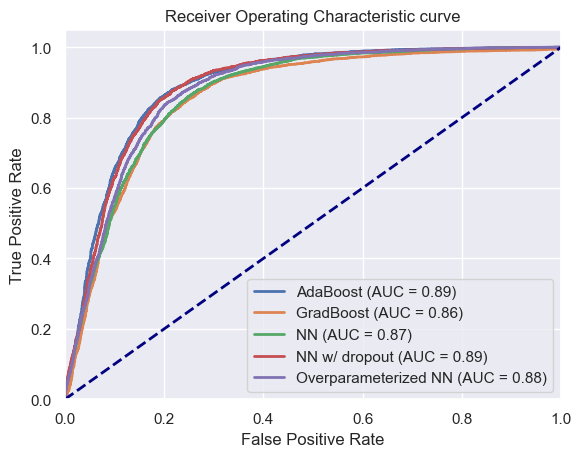

In [64]:
print('Adaptive boost: train score', fitted_bdt_ada.score(X_train, y_train.ravel()),', test score', fitted_bdt_ada.score(X_test, y_test.ravel()))
print('Gradient boost: train score', fitted_bdt_grad.score(X_train, y_train.ravel()),', test score', fitted_bdt_grad.score(X_test, y_test.ravel()))
#print(nn_model.predict(X_train)[:,0] >=0.5)
print('NN: train score', accuracy_score(y_train.ravel(), nn_model.predict(X_train, batch_size=len(X_train))[:,0]>=0.5),', test score', accuracy_score(y_test.ravel(), nn_model.predict(X_test, batch_size=len(X_train))[:,0]>=0.5))
print('NN w/ dropout: train score', accuracy_score(y_train.ravel(), dropout_nn_model.predict(X_train, batch_size=len(X_train))[:,0]>=0.5),', test score', accuracy_score(y_test.ravel(), dropout_nn_model.predict(X_test, batch_size=len(X_train))[:,0]>=0.5))
print('NN (overparameterized): train score', accuracy_score(y_train.ravel(), ov_nn_model.predict(X_train, batch_size=len(X_train))[:,0]>=0.5),', test score', accuracy_score(y_test.ravel(), ov_nn_model.predict(X_test, batch_size=len(X_train))[:,0]>=0.5))

plot_rocs([ [fitted_bdt_ada.decision_function(X_test), 'AdaBoost'],
            [fitted_bdt_grad.decision_function(X_test), 'GradBoost'],
            [nn_model.predict(X_test)[:,0], 'NN'  ],
            [dropout_nn_model.predict(X_test)[:,0], 'NN w/ dropout'  ],
            [ov_nn_model.predict(X_test)[:,0], 'Overparameterized NN']
          ],
          y_test)

In [65]:
ov_nn_allweights = ov_nn_model.trainable_weights


totpar=0
for perlayer in ov_nn_allweights:
    print(perlayer.shape)
    totpar+= perlayer.shape[0]*perlayer.shape[1] if len(perlayer.shape)>1 else (perlayer.shape[0] if len(perlayer.shape)==1 else 0)

print(totpar)


ov_nn_model.summary()

(28, 400)
(400,)
(400, 112)
(112,)
(112, 112)
(112,)
(112, 28)
(28,)
(28, 14)
(14,)
(14, 1)
(1,)
72753
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 400)               11600     
                                                                 
 dense_12 (Dense)            (None, 112)               44912     
                                                                 
 dense_13 (Dense)            (None, 112)               12656     
                                                                 
 dense_14 (Dense)            (None, 28)                3164      
                                                                 
 dense_15 (Dense)            (None, 14)                406       
                                                                 
 dense_16 (Dense)            (None, 1)                 15        
                 

### Double descent

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 84)                2436      
                                                                 
 batch_normalization (BatchN  (None, 84)               336       
 ormalization)                                                   
                                                                 
 dense_18 (Dense)            (None, 56)                4760      
                                                                 
 batch_normalization_1 (Batc  (None, 56)               224       
 hNormalization)                                                 
                                                                 
 dense_19 (Dense)            (None, 28)                1596      
                                                                 
 batch_normalization_2 (Batc  (None, 28)              

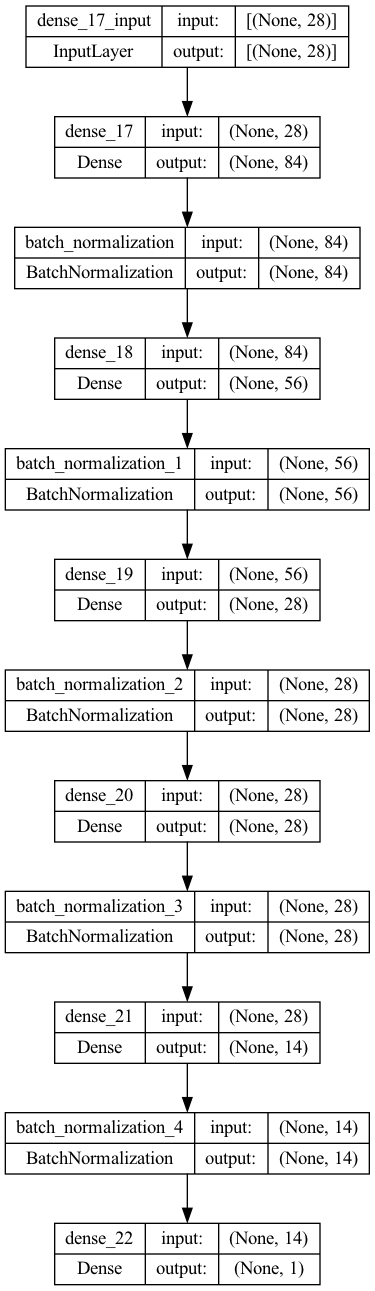

In [66]:
len(train_set)

n_neurons=400


n_neurons_per_layer=[2*n_inputs, n_inputs, n_inputs, int(n_inputs/2)]
n_hidden_layers=len(n_neurons_per_layer)

crit_nn_model = Sequential()

# Input layer (no activation function here)
crit_nn_model.add(Dense(3*n_inputs, input_dim=n_inputs, kernel_initializer=kernel_initializer))
crit_nn_model.add(BatchNormalization())

# Hidden layers
for i in range(n_hidden_layers):
    crit_nn_model.add(Dense(n_neurons_per_layer[i], activation='relu', kernel_initializer=kernel_initializer))
    crit_nn_model.add(BatchNormalization())

# Output layer
crit_nn_model.add(Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer))


# NOTE: first try without the new learning rate
def lr_scheduler(epoch):
    default_lr = 0.00001
    drop = 0.90
    epochs_drop = 5.0
    lr = default_lr * math.pow(drop, math.floor(epoch/epochs_drop))
    #lr = default_lr * math.pow(drop, min(1, math.floor((1 + epoch)/epochs_drop)))
                    
    return lr
optimizer = Adam(learning_rate=0.01*adam_learning_rate)
crit_nn_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

callbacks = []
callbacks.append(keras.callbacks.ModelCheckpoint("crit_nn_weights.h5", monitor='val_loss', verbose=False, save_best_only=True, mode='auto'))

callbacks.append(keras.callbacks.LearningRateScheduler(lr_scheduler))
callbacks.append(PlotLossesKeras())

crit_nn_model.summary()

plot_model(crit_nn_model,show_shapes=True, show_layer_names=True)


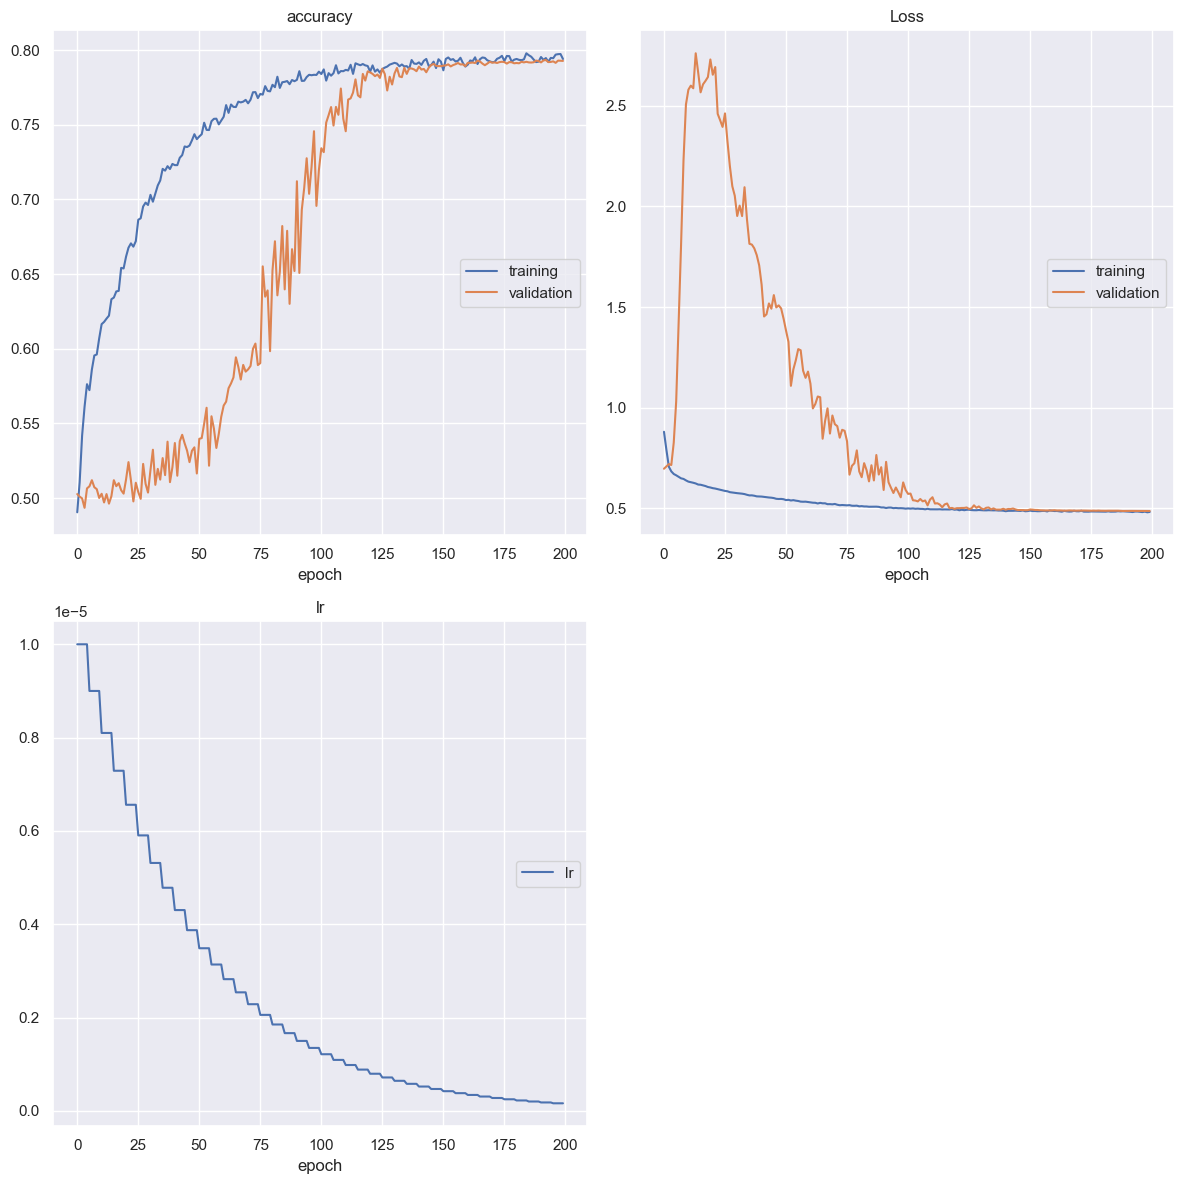

accuracy
	training         	 (min:    0.491, max:    0.798, cur:    0.794)
	validation       	 (min:    0.493, max:    0.793, cur:    0.793)
Loss
	training         	 (min:    0.480, max:    0.880, cur:    0.481)
	validation       	 (min:    0.486, max:    2.762, cur:    0.486)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)
79/79 [==============================] - 2s 23ms/step - loss: 0.4814 - accuracy: 0.7941 - val_loss: 0.4861 - val_accuracy: 0.7928 - lr: 1.6423e-07
Training took 0:05:58.633366 seconds.


In [67]:
batch_size = 128
epochs = 200
start_time = timer()

crit_history = crit_nn_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
            verbose=True, validation_data=(X_test, y_test), callbacks=callbacks)
end_time = timer()
crit_nn_model.load_weights('crit_nn_weights.h5')

training_time = datetime.timedelta(seconds=(end_time - start_time))
print('Training took', training_time, 'seconds.')

#save_training_pa

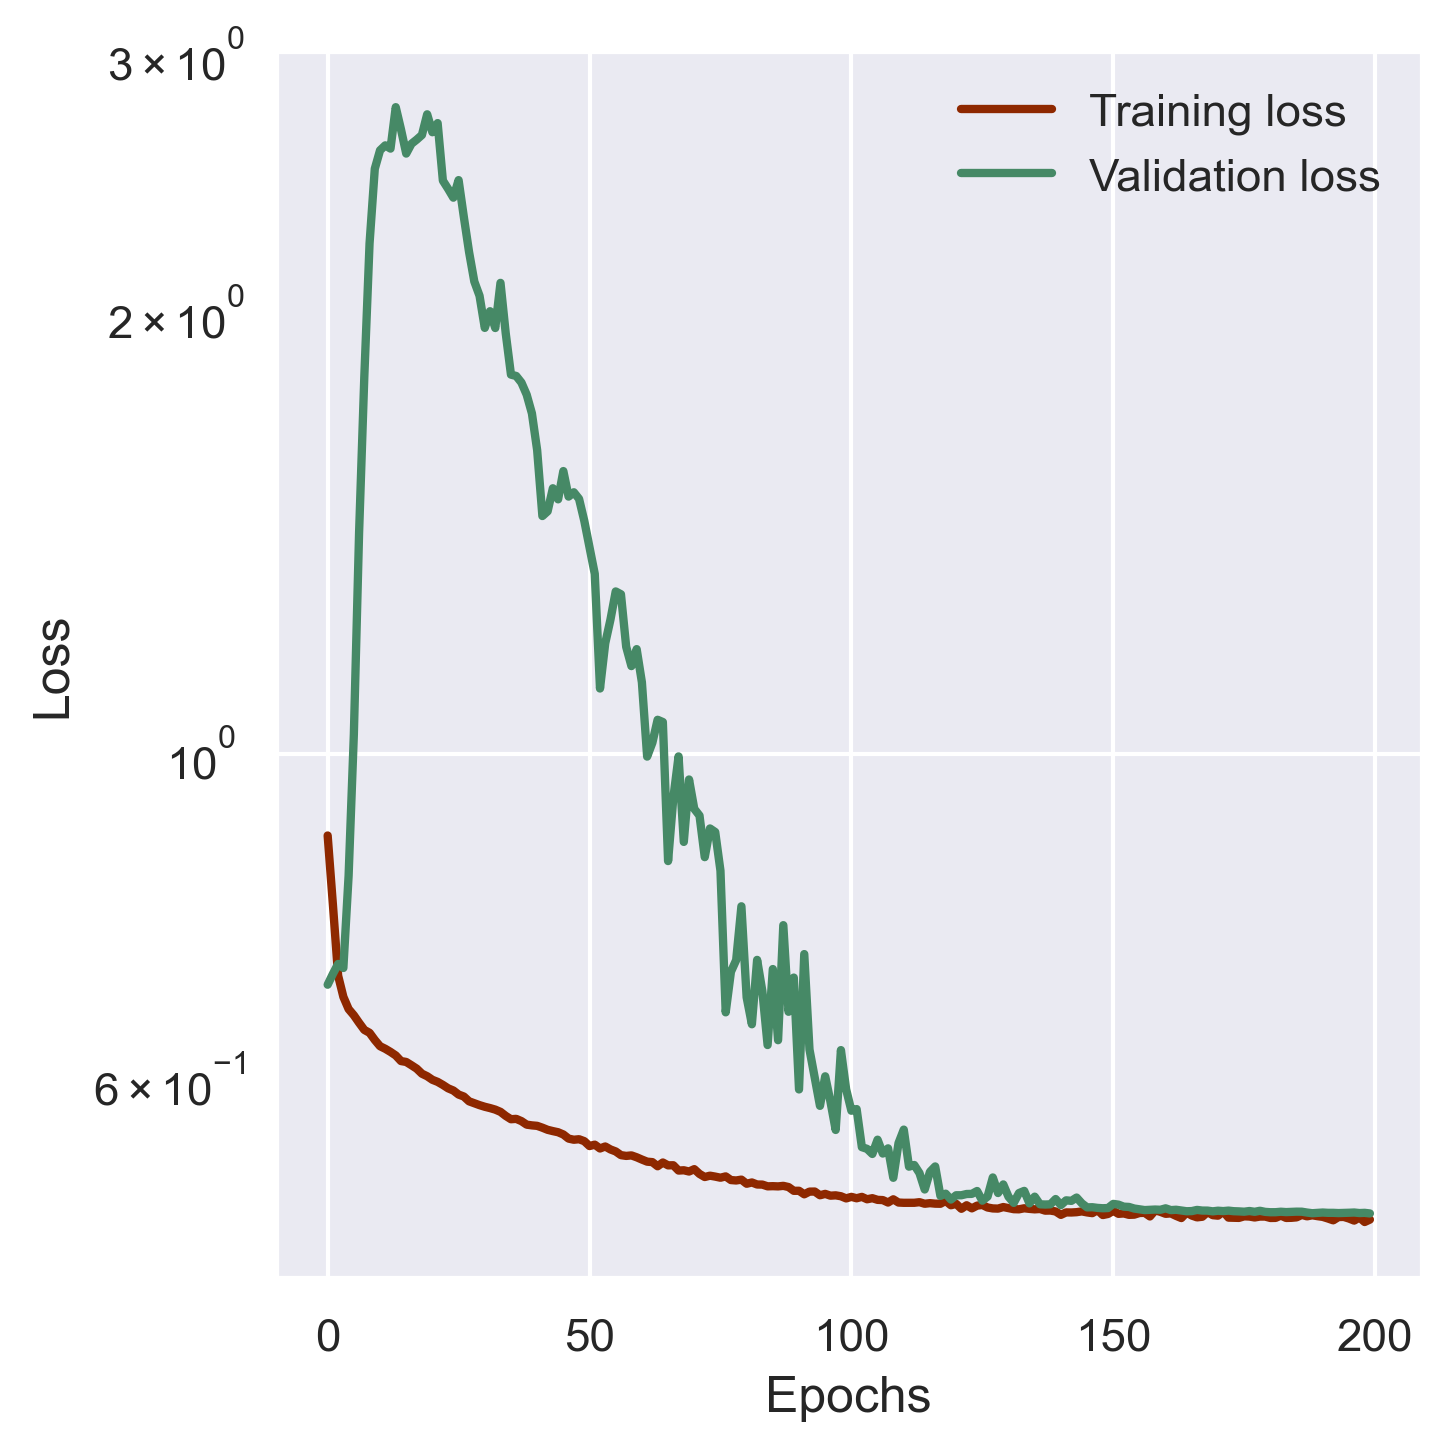

In [68]:
plot_losses(crit_history)

Adaptive boost: train score 0.8532 , test score 0.8315
Gradient boost: train score 0.9308 , test score 0.7997
1/1 [==============================] - 0s 8ms/step
NN: train score 0.81 , test score 0.7997
1/1 [==============================] - 0s 10ms/step
NN w/ dropout: train score 0.8372 , test score 0.8281
1/1 [==============================] - 0s 8ms/step
NN (overparameterized): train score 0.8213 , test score 0.8153
1/1 [==============================] - 0s 14ms/step
NN (critical regime): train score 0.8003 , test score 0.7928
313/313 [==============================] - 1s 3ms/step


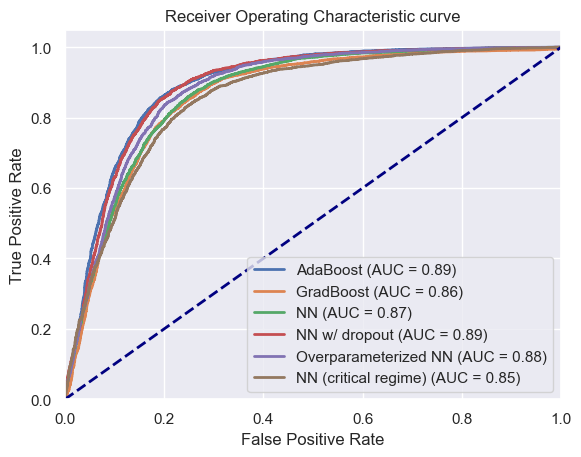

In [69]:
print('Adaptive boost: train score', fitted_bdt_ada.score(X_train, y_train.ravel()),', test score', fitted_bdt_ada.score(X_test, y_test.ravel()))
print('Gradient boost: train score', fitted_bdt_grad.score(X_train, y_train.ravel()),', test score', fitted_bdt_grad.score(X_test, y_test.ravel()))
#print(nn_model.predict(X_train)[:,0] >=0.5)
print('NN: train score', accuracy_score(y_train.ravel(), nn_model.predict(X_train, batch_size=len(X_train))[:,0]>=0.5),', test score', accuracy_score(y_test.ravel(), nn_model.predict(X_test, batch_size=len(X_train))[:,0]>=0.5))
print('NN w/ dropout: train score', accuracy_score(y_train.ravel(), dropout_nn_model.predict(X_train, batch_size=len(X_train))[:,0]>=0.5),', test score', accuracy_score(y_test.ravel(), dropout_nn_model.predict(X_test, batch_size=len(X_train))[:,0]>=0.5))
print('NN (overparameterized): train score', accuracy_score(y_train.ravel(), ov_nn_model.predict(X_train, batch_size=len(X_train))[:,0]>=0.5),', test score', accuracy_score(y_test.ravel(), ov_nn_model.predict(X_test, batch_size=len(X_train))[:,0]>=0.5))
print('NN (critical regime): train score', accuracy_score(y_train.ravel(), crit_nn_model.predict(X_train, batch_size=len(X_train))[:,0]>=0.5),', test score', accuracy_score(y_test.ravel(), crit_nn_model.predict(X_test, batch_size=len(X_train))[:,0]>=0.5))

plot_rocs([ [fitted_bdt_ada.decision_function(X_test), 'AdaBoost'],
            [fitted_bdt_grad.decision_function(X_test), 'GradBoost'],
            [nn_model.predict(X_test)[:,0], 'NN'  ],
            [dropout_nn_model.predict(X_test)[:,0], 'NN w/ dropout'  ],
            [ov_nn_model.predict(X_test)[:,0], 'Overparameterized NN'],
            [crit_nn_model.predict(X_test)[:,0], 'NN (critical regime)']
          ],
          y_test)

#### Double descent in a more noisy data set

In [70]:
# Load the chosen set
train_set=pd.read_csv('data/not1000_750_train_small.csv', index_col=False)
test_set=pd.read_csv('data/not1000_750_test_small.csv', index_col=False)

# Drop mass info, if needed (the "1000..." files don't have a 'mass' column)
if 'mass' in train_set.columns:
    train_set=train_set.drop(['mass'], axis=1)
    test_set=test_set.drop(['mass'], axis=1)
train_set.head()

,Unnamed: 0,label,f0,f1,f2,f3,f4,f5,f6,f7,...,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26
0,1,1.0,-1.401979,-0.942620,1.049402,1.637764,1.681190,-0.005984,0.733926,-0.476641,...,-0.815440,-0.822903,0.156014,-0.197154,1.743123,0.361093,-0.941934,0.026127,1.396366,-0.123928
1,12,0.0,-0.646328,0.132367,0.864149,0.596158,0.266139,-1.054221,-0.801212,0.231854,...,1.226331,-1.368451,-0.189723,-1.710976,-0.573682,-0.800589,-0.594036,-0.377533,-0.113845,-1.300184
2,13,1.0,-0.093261,0.168337,1.287353,0.319592,-1.359426,1.574625,0.988875,-0.268706,...,-0.815440,1.634929,-0.067125,-1.548938,1.743123,-0.015264,-0.080968,0.756942,0.879847,0.218808
3,16,1.0,1.205673,1.103310,-1.132657,-1.284128,-0.823548,0.850488,0.943595,0.516031,...,1.226331,0.383688,-0.162711,1.030514,-0.573682,-0.739276,-0.147738,-0.270474,-0.256237,0.318978
4,19,0.0,-1.134711,1.257473,-0.419845,-0.848054,-1.568315,-1.054221,-0.144344,-0.077036,...,-0.815440,-0.278497,0.340343,0.306618,-0.573682,-0.384413,-0.364842,-0.309805,-0.673690,-0.957803


1000
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 28)                812       
                                                                 
 batch_normalization_5 (Batc  (None, 28)               112       
 hNormalization)                                                 
                                                                 
 dense_24 (Dense)            (None, 9)                 261       
                                                                 
 batch_normalization_6 (Batc  (None, 9)                36        
 hNormalization)                                                 
                                                                 
 dense_25 (Dense)            (None, 1)                 10        
                                                                 
Total params: 1,231
Trainable params: 1,157
Non-t

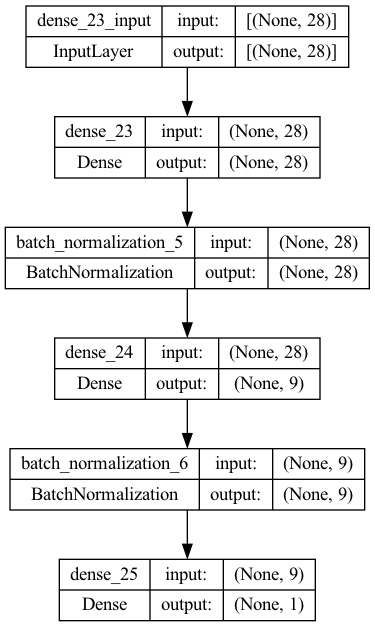

In [71]:
print(len(train_set))

n_neurons=400


n_neurons_per_layer=[int(n_inputs/3)]
n_hidden_layers=len(n_neurons_per_layer)

noise_nn_model = Sequential()

# Input layer (no activation function here)
noise_nn_model.add(Dense(n_inputs, input_dim=n_inputs, kernel_initializer=kernel_initializer))
noise_nn_model.add(BatchNormalization())

# Hidden layers
for i in range(n_hidden_layers):
    noise_nn_model.add(Dense(n_neurons_per_layer[i], activation='relu', kernel_initializer=kernel_initializer))
    noise_nn_model.add(BatchNormalization())

# Output layer
noise_nn_model.add(Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer))


# NOTE: first try without the new learning rate
def lr_scheduler(epoch):
    default_lr = 0.00001
    drop = 0.7#0.90
    epochs_drop = 5.0
    #lr = default_lr * math.pow(drop, math.floor(epoch/epochs_drop))
    lr = default_lr * math.pow(drop, min(1, math.floor((1 + epoch)/epochs_drop)))
    return lr
optimizer = Adam(learning_rate=0.01*adam_learning_rate)
noise_nn_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

callbacks = []
callbacks.append(keras.callbacks.ModelCheckpoint("noise_nn_weights.h5", monitor='val_loss', verbose=False, save_best_only=True, mode='auto'))

callbacks.append(keras.callbacks.LearningRateScheduler(lr_scheduler))
callbacks.append(PlotLossesKeras())

noise_nn_model.summary()

plot_model(noise_nn_model,show_shapes=True, show_layer_names=True)


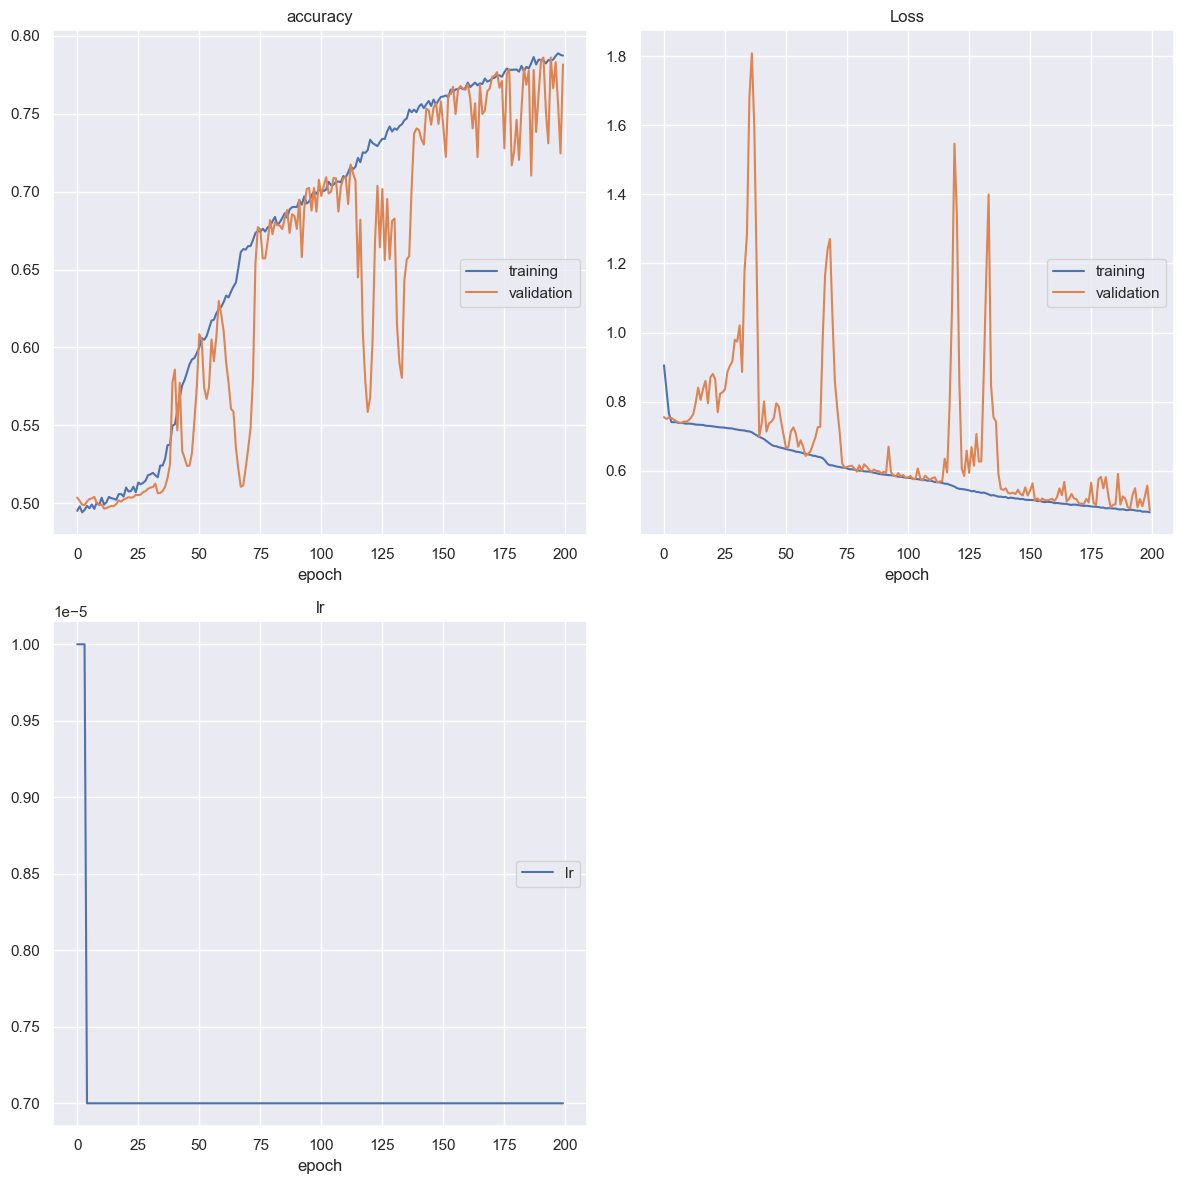

accuracy
	training         	 (min:    0.494, max:    0.789, cur:    0.787)
	validation       	 (min:    0.497, max:    0.786, cur:    0.782)
Loss
	training         	 (min:    0.479, max:    0.905, cur:    0.479)
	validation       	 (min:    0.486, max:    1.808, cur:    0.486)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)
79/79 [==============================] - 1s 15ms/step - loss: 0.4795 - accuracy: 0.7873 - val_loss: 0.4858 - val_accuracy: 0.7817 - lr: 7.0000e-06
Training took 0:04:15.186199 seconds.


In [72]:
batch_size = 128
epochs = 200
start_time = timer()

noise_history = noise_nn_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
            verbose=True, validation_data=(X_test, y_test), callbacks=callbacks)
end_time = timer()
noise_nn_model.load_weights('noise_nn_weights.h5')

training_time = datetime.timedelta(seconds=(end_time - start_time))
print('Training took', training_time, 'seconds.')

#save_training_pa

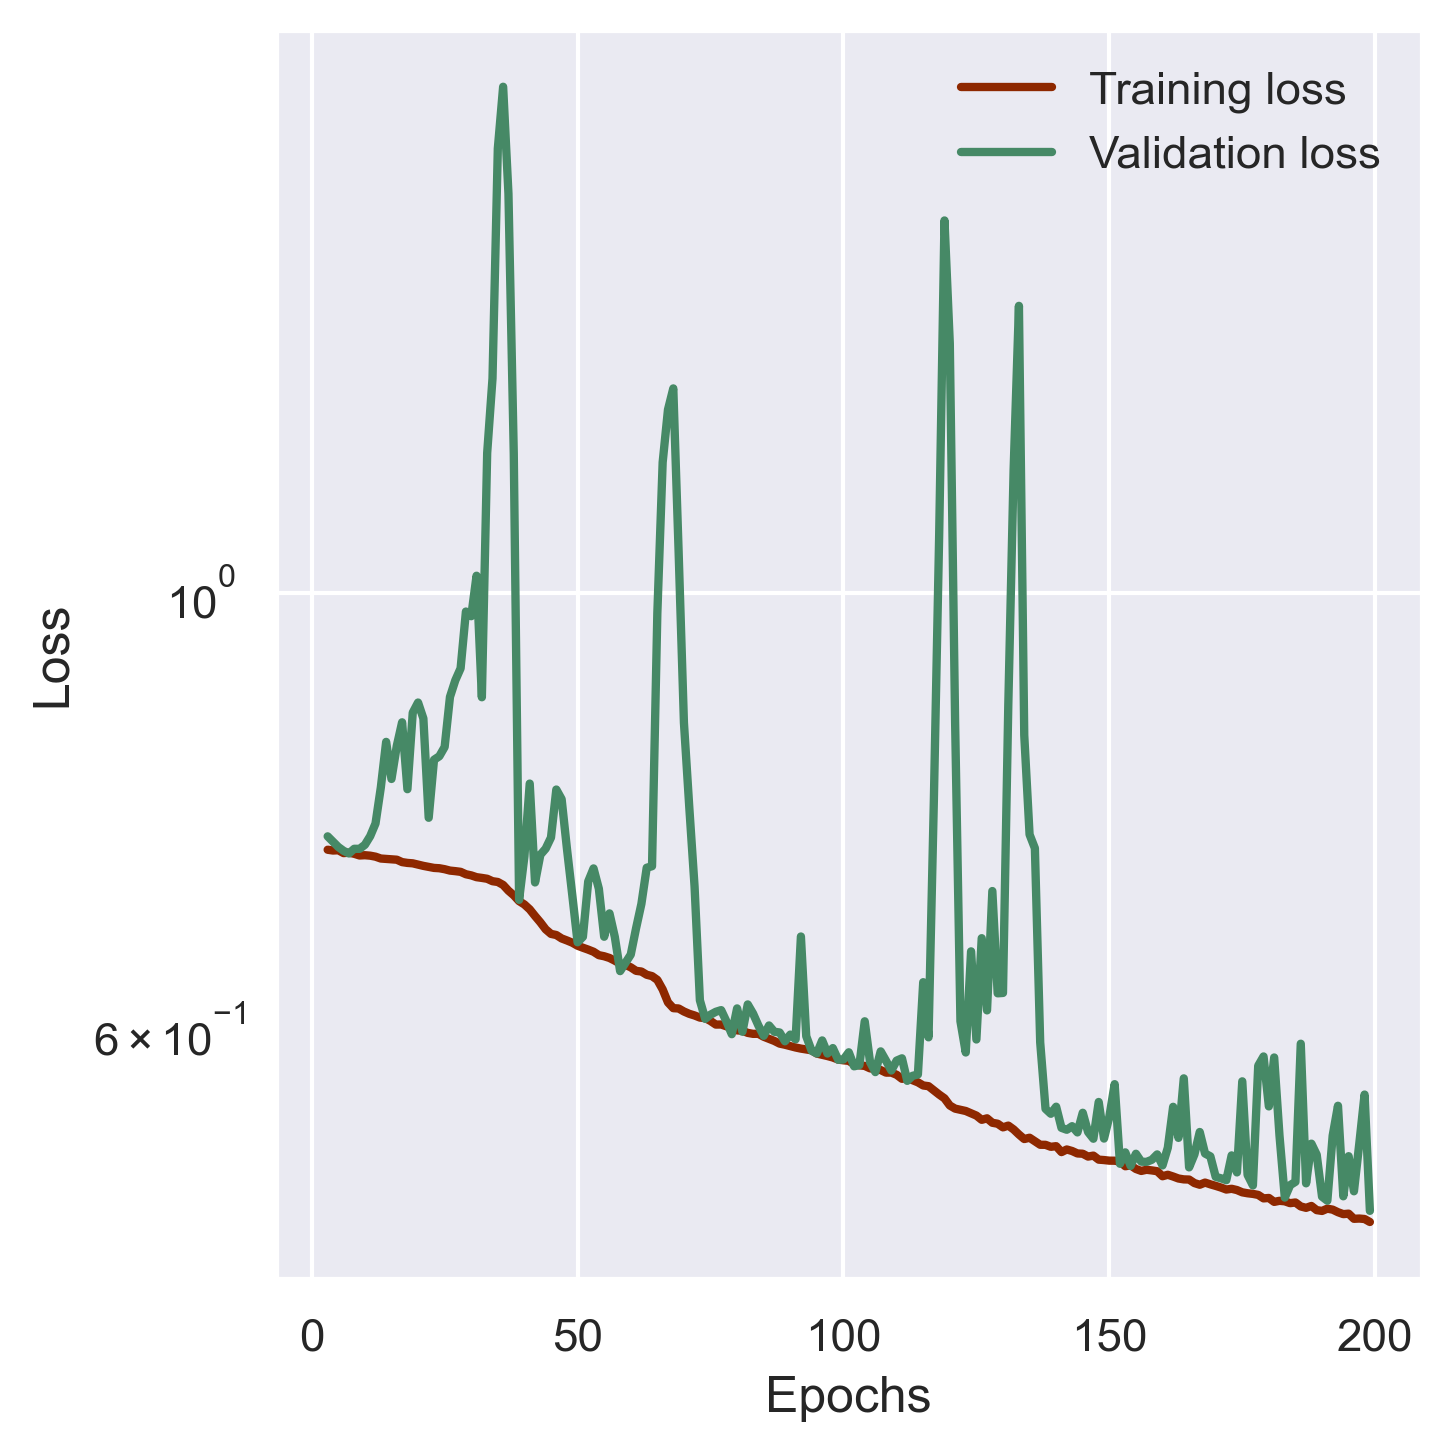

In [73]:
plot_losses(noise_history, 3)

### The end